# Analyze Prometheus Data and Obtain Report

In [ ]:
from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
import re
run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-09-24-20-50-38/run_0"
GRAN = "30s"
memory_metric = "vllm:gpu_cache_usage_perc"
compute_metric = f"rate(vllm:iteration_tokens_total_sum[{GRAN}]) / rate(vllm:iteration_tokens_total_count[{GRAN}])"
queue_metric = f"rate(vllm:request_queue_time_seconds_sum[{GRAN}])"
throughput_metric = f"rate(vllm:iteration_tokens_total_sum[{GRAN}])"
# throughput_metric = f"vllm:avg_generation_throughput_toks_per_s"
req_counter_metric = f"router:req_counter"
rps_counter_metric = f"router:rps_counter"
tok_counter_metric = f"router:tok_counter"
tps_counter_metric = f"router:tps_counter"
ins_counter_metric = f"router:ins_counter"
ins_needed_metric = f"router:ins_needed"
tps_counter_map_metric = f"router:tps_counter_map"
coldstart_metric = f"router:create_instance_duration_seconds"
metrics_list = [memory_metric, compute_metric, throughput_metric, req_counter_metric, ins_counter_metric, ins_needed_metric, tok_counter_metric, queue_metric, rps_counter_metric, coldstart_metric, tps_counter_metric, tps_counter_map_metric]
report_file_path = analyze_data(run_log_dir, metrics_list)
with open(report_file_path, 'r') as f:
    report = json.load(f)

loadgen_data = report['loadgen_data']
total_request_count = len(loadgen_data)
no_response_count = 0
error_count = 0
skip_prefill_requests = []
requests = []
for request_data in loadgen_data:
    if 'error' not in request_data.keys():
        request = RequestData.init_from_dict(request_data)
        requests.append(request)
        if request.waiting_latency == 0:
            skip_prefill_requests.append(request)
        continue

    if request_data == {'error': 'No response!'}:
        no_response_count += 1
    else:
        error_count += 1
        print(request_data)

print(f"Total request: {total_request_count}, no response: {no_response_count}, error: {error_count}, skip prefill: {len(skip_prefill_requests)}")
recv_kv_failed_requests = report['recv_failed_requests']
print(f"There are totally {len(recv_kv_failed_requests)} requests fall back to model forwarding!")

start_str = report.get('router_start_time', 'N/A')
end_str = report.get('router_end_time', 'N/A')
print(start_str, end_str)
tz_sg = ZoneInfo("Asia/Singapore")
router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()
pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}) Finished preparing http requests")
with open(f"{run_log_dir}/loadgen.err") as f:
    for line in f:
        m = pattern.match(line)
        if m:
            dt = datetime.strptime(m.group(1), "%Y/%m/%d %H:%M:%S").replace(tzinfo=tz_sg)
            break

first_request_sendtime = dt.timestamp() + 5
print(f"Router start time: {router_start_time}, end time: {router_end_time}")

Starting Prometheus...


ts=2025-09-24T13:11:03.044Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-09-24T13:11:03.045Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-09-24T13:11:03.045Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-09-24T13:11:03.045Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 d8afb290140f (none))"
ts=2025-09-24T13:11:03.045Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-09-24T13:11:03.045Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-09-24T13:11:03.055Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['vllm:gpu_cache_usage_perc', 'rate(vllm:iteration_tokens_total_sum[30s]) / rate(vllm:iteration_tokens_total_count[30s])', 'rate(vllm:iteration_tokens_total_sum[30s])', 'router:req_counter', 'router:ins_counter', 'router:ins_needed', 'router:tok_counter', 'rate(vllm:request_queue_time_seconds_sum[30s])', 'router:rps_counter', 'router:create_instance_duration_seconds', 'router:tps_counter', 'router:tps_counter_map']
params_list: [{'query': 'vllm:gpu_cache_usage_perc', 'start': '2025-09-24T11:44:48Z', 'end': '2025-09-24T13:44:48Z', 'step': '1s'}, {'query': 'rate(vllm:iteration_tokens_total_sum[30s]) / rate(vllm:iteration_tokens_total_count[30s])', 'start': '2025-09-24T11:44:48Z', 'end': '2025-09-24T13:44:48Z', 'step': '1s'}, {'query': 'rate(vllm:iteration_tokens_total_sum[30s])', 'start': '2025-09-24T11:44:48Z', 'end': '2025-09-24T13:44:48Z', 'step': '1s'}, {'query': 'router:req_counter', 'start': '2025-09-24T11:44:48Z', 'end': '2025-09-24T13:44:

# Plot Prometheus Data

In [4]:
import matplotlib.pyplot as plt
from datetime import datetime
def add_metric_plot(metrics, metric_name: str, ax, color, ylabel):
    series = metrics.get(metric_name, [])
    times = [float(t[0]) - router_start_time for t in series]
    values = [float(t[1]) for t in series]
    if times == []:
        return
    sorted_pairs = sorted(zip(times, values))
    times_sorted, values_sorted = zip(*sorted_pairs)

    ax.plot(times_sorted, values_sorted, color=color)
    ax.set_xlim(first_request_sendtime - router_start_time, router_end_time - router_start_time)
    ax.set_ylabel(ylabel, color=color)

# GPU Specific Metrics

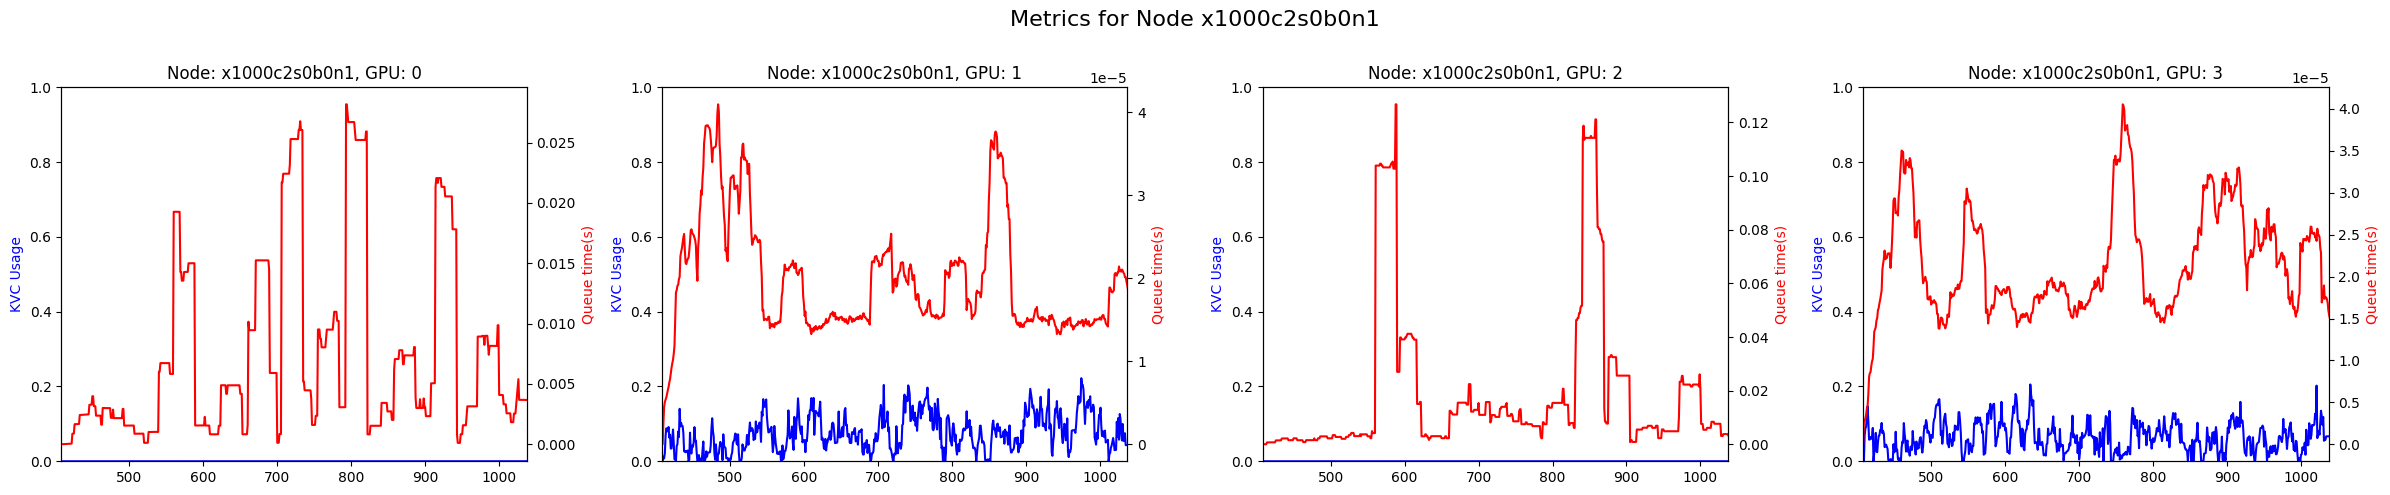

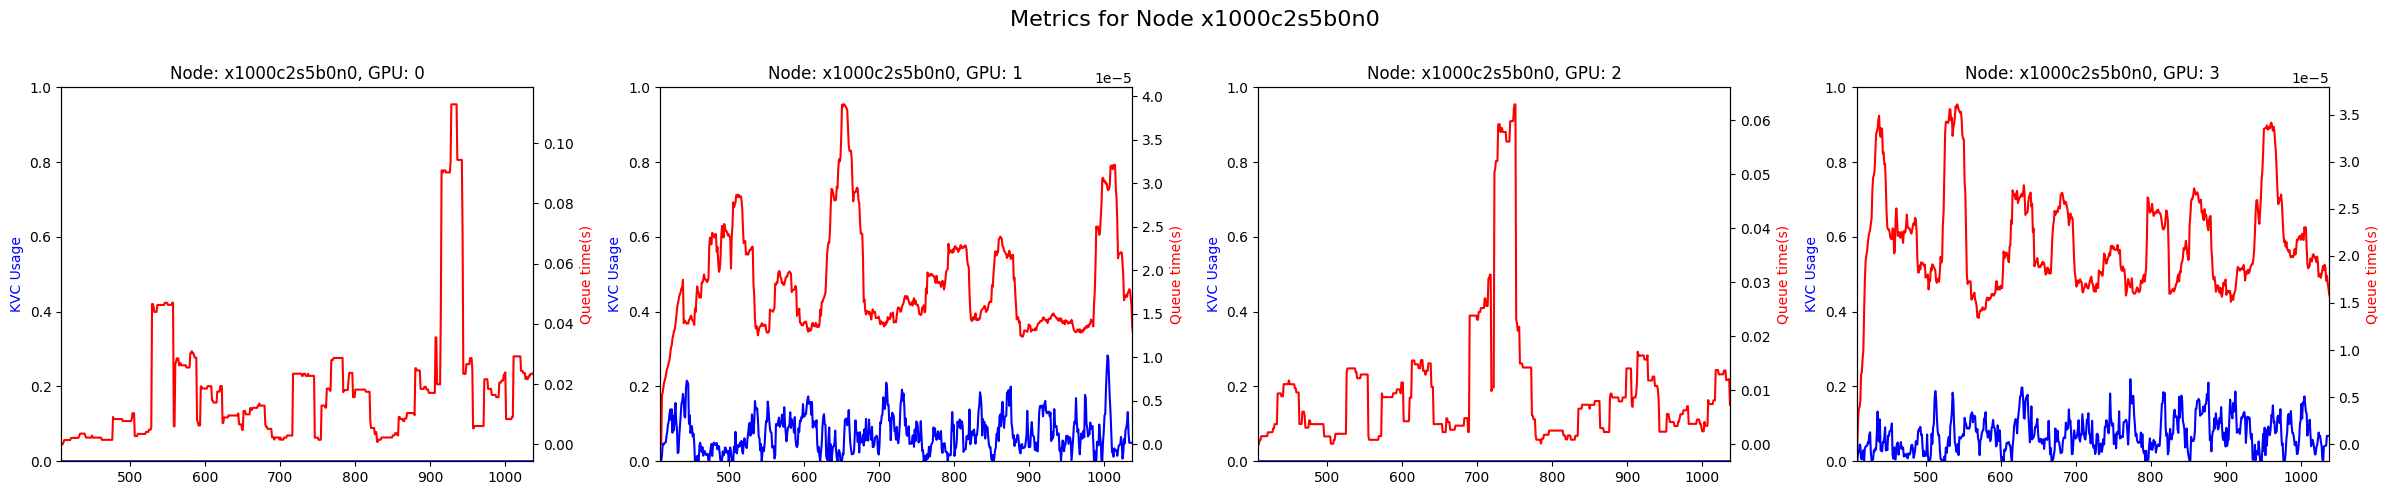

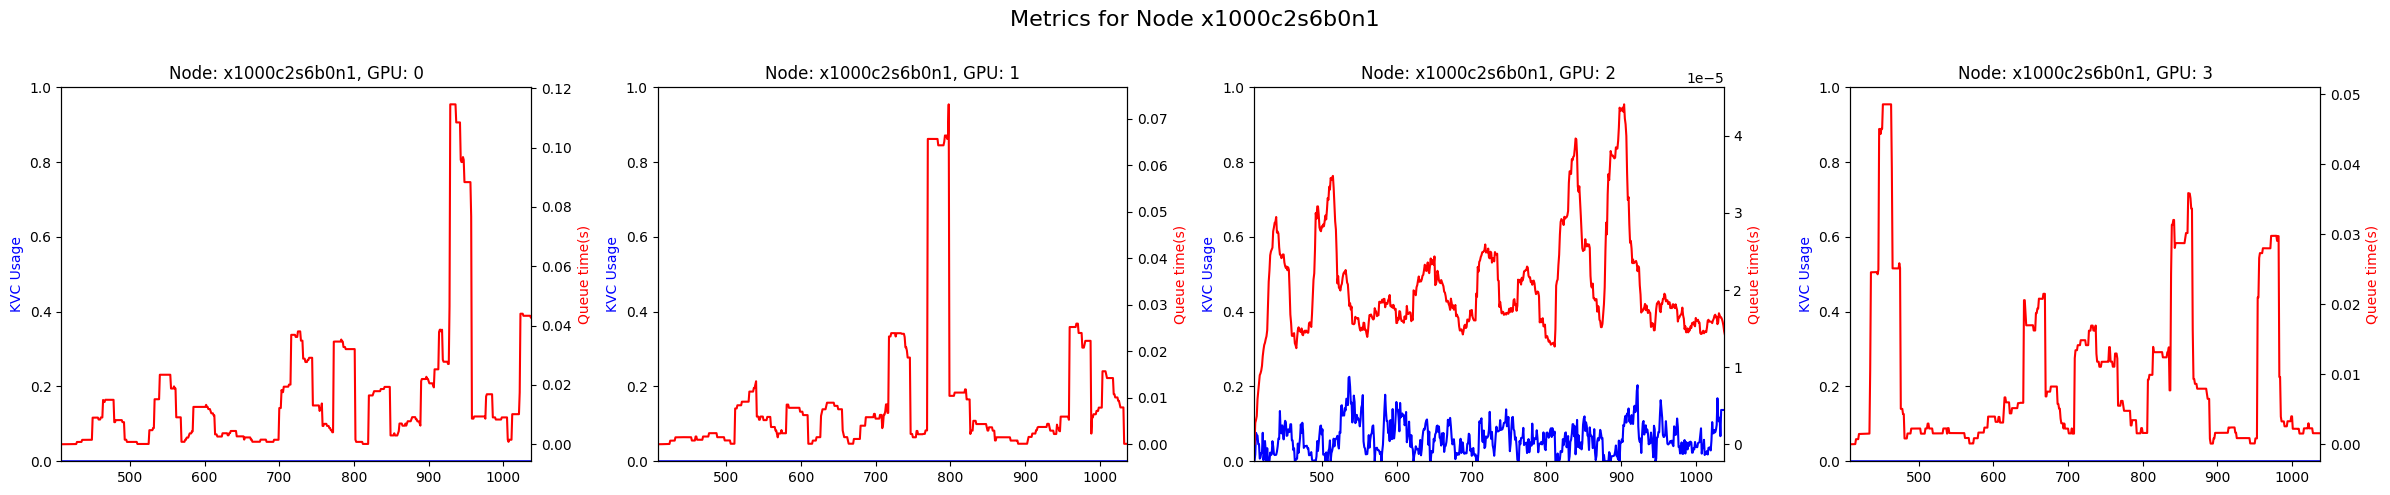

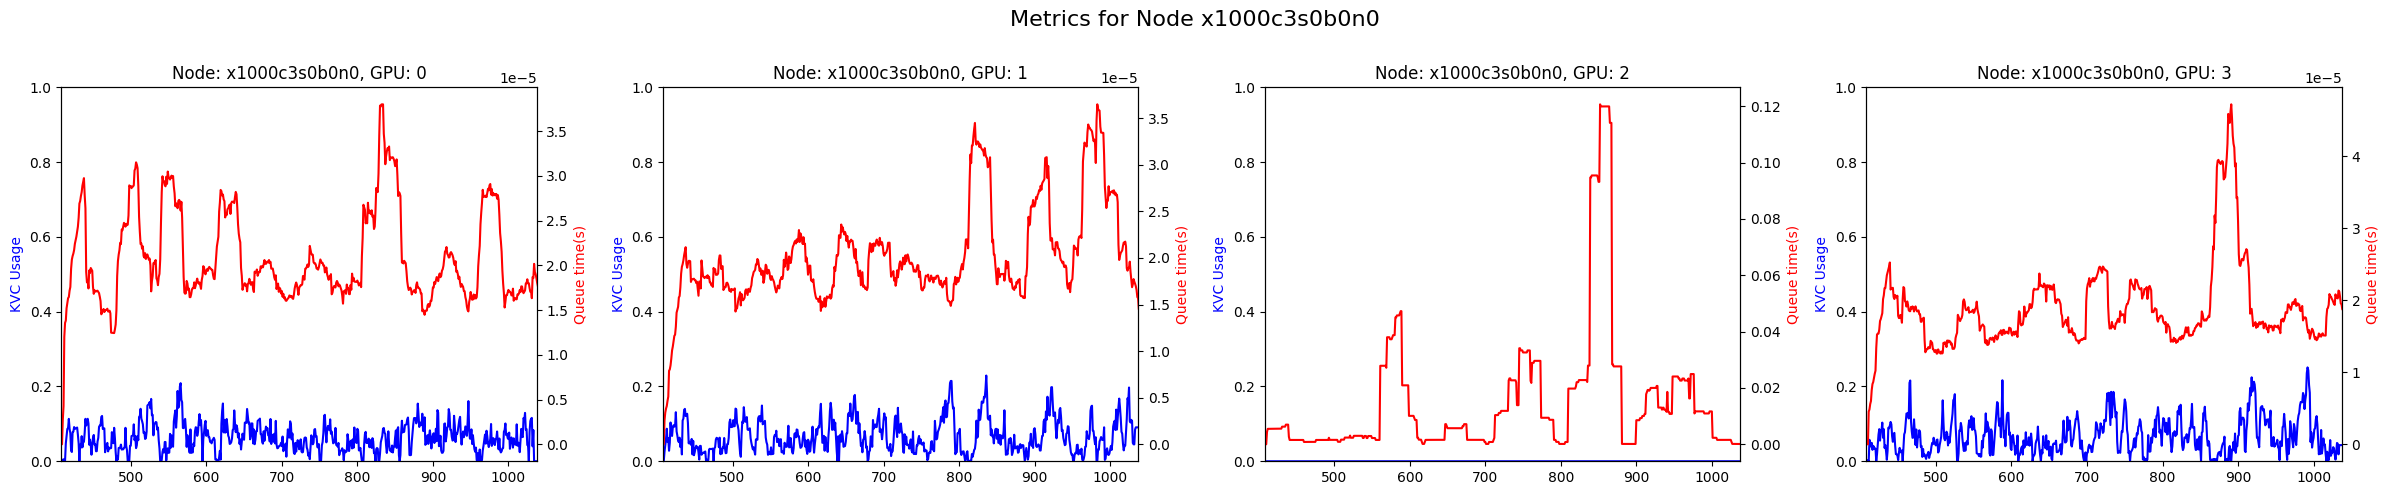

In [5]:
from collections import defaultdict
import math
import matplotlib.pyplot as plt

# Group metrics by node
data = report['prom_data']
node_data = defaultdict(dict)

for instance_uuid, metrics in data.items():
    if instance_uuid == "router": 
        continue
    node, gpu_str = instance_uuid.split("-")
    gpu_id = int(gpu_str)
    node_data[node][gpu_id] = metrics

# Plot per node
for node, gpu_metrics in node_data.items():
    max_gpu_id = max(gpu_metrics.keys())
    nrows = math.ceil((max_gpu_id + 1) / 4)
    ncols = 4

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), sharex=True)
    axes = axes.reshape(nrows, ncols)

    for gpu_id, metrics in gpu_metrics.items():
        row, col = divmod(gpu_id, 4)
        ax = axes[row, col]

        add_metric_plot(metrics, memory_metric, ax, color="blue", ylabel="KVC Usage")
        ax.set_ylim([0, 1])

        ax2 = ax.twinx()
        add_metric_plot(metrics, queue_metric, ax2, color="red", ylabel="Queue time(s)")

        ax.set_title(f"Node: {node}, GPU: {gpu_id}")


    plt.suptitle(f"Metrics for Node {node}", fontsize=16)
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
    plt.show()

# Receiver Specific Data

Model meta-llama/Llama-3.1-8B::prefill has 8 instances.


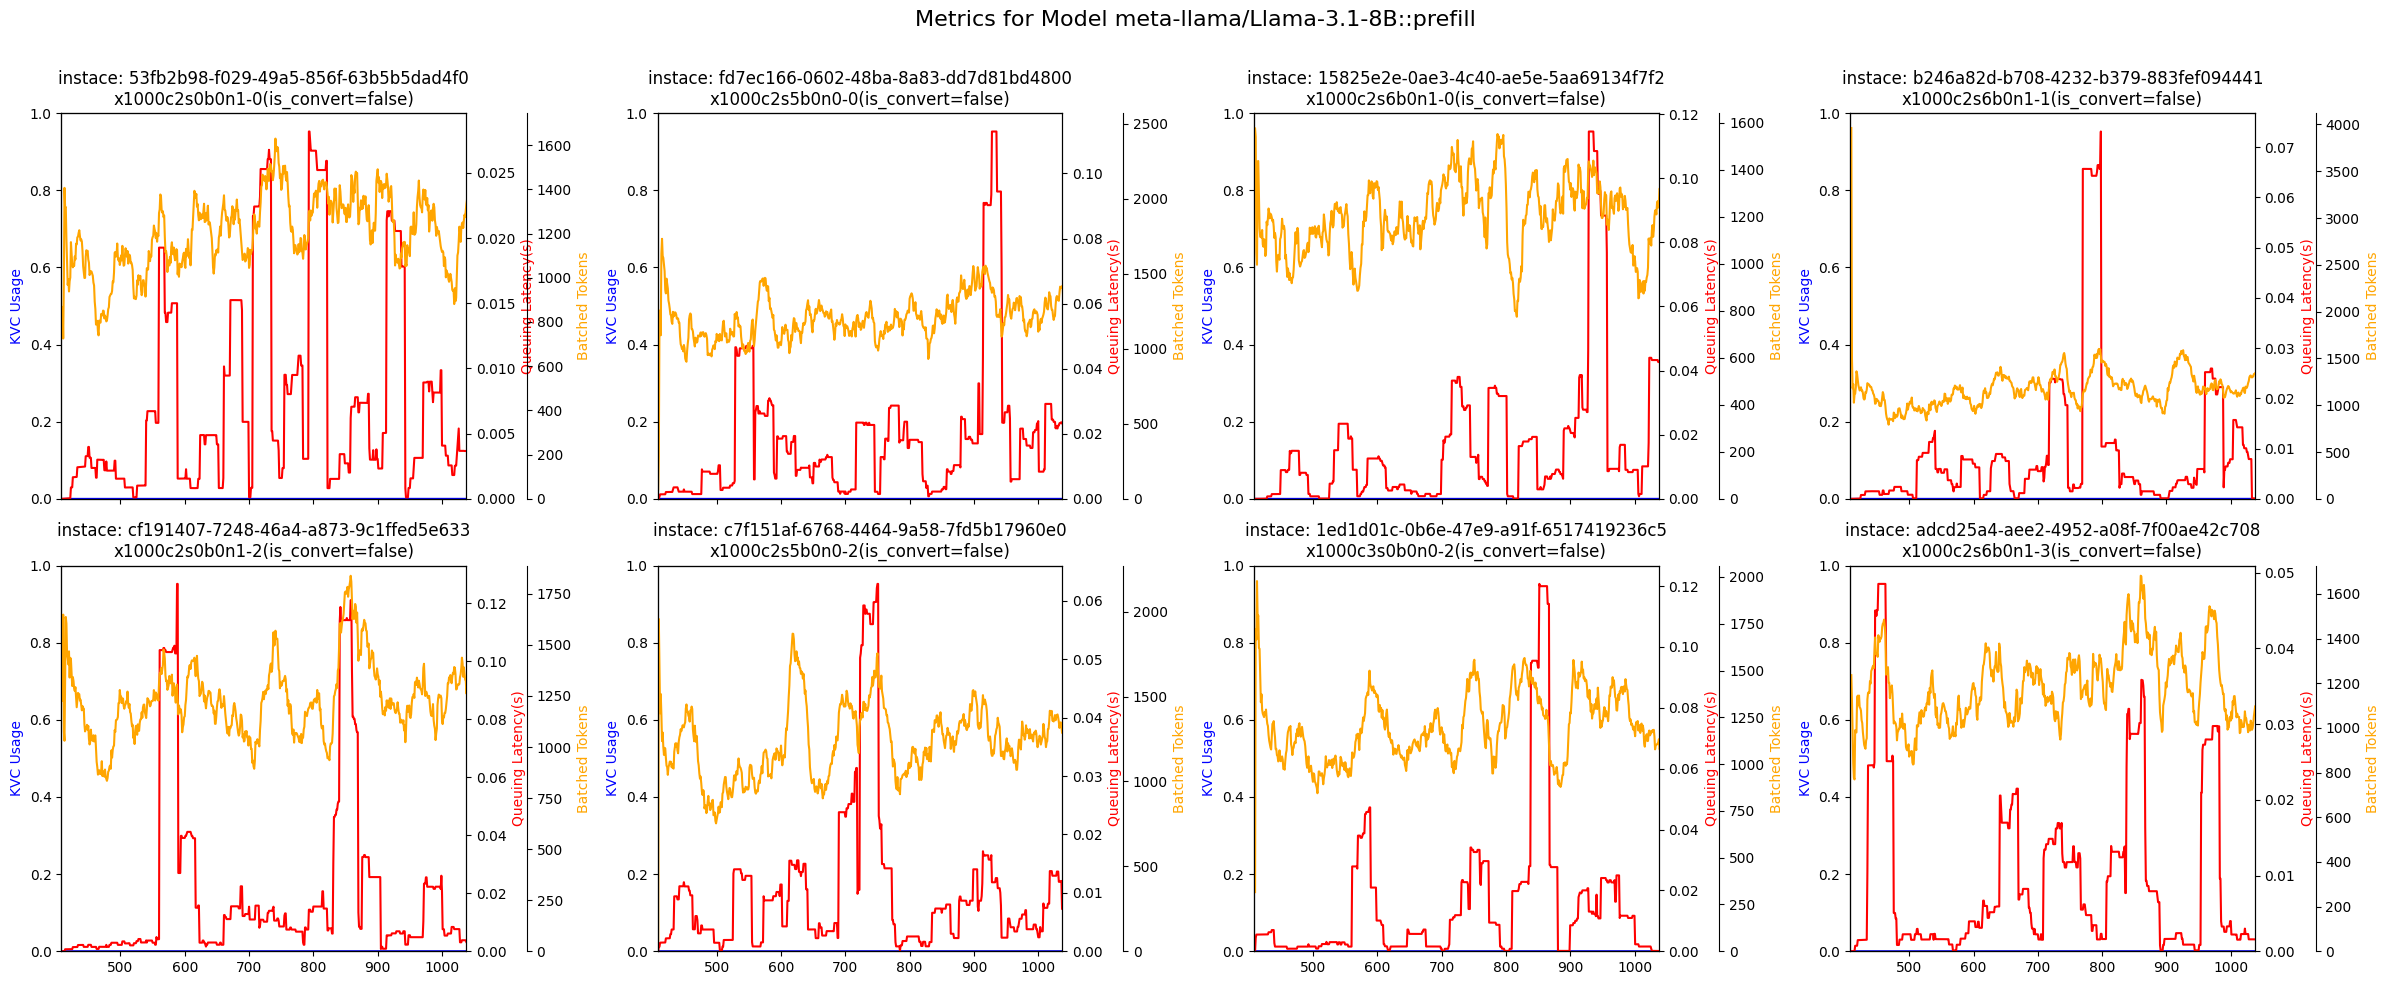

Model meta-llama/Llama-3.1-8B::decode has 8 instances.


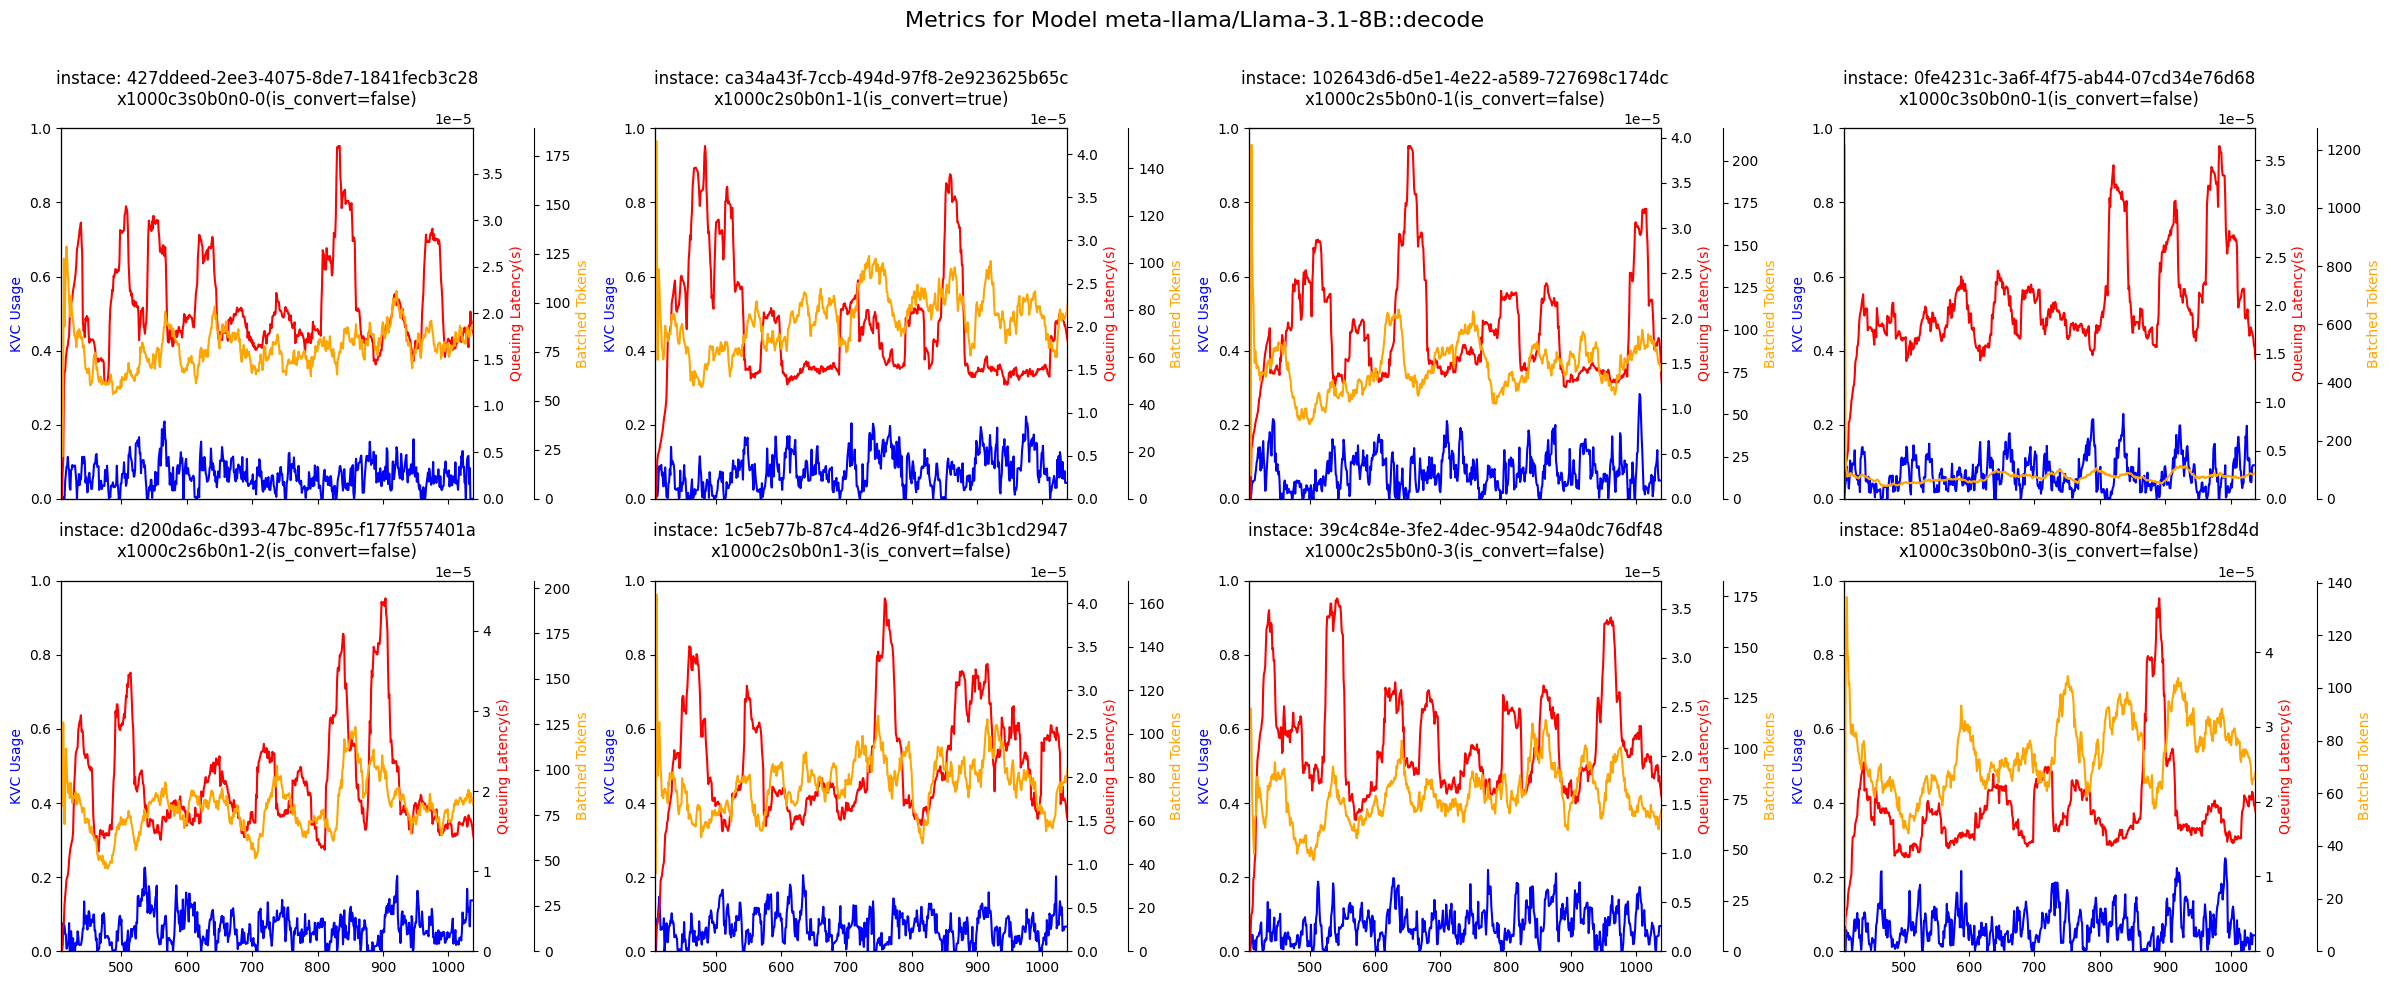

In [6]:

instance_data = report['prom_instance_data']
model_metrics_map = {}
for instance_uuid, metrics in instance_data.items():
    model = metrics['metadata']['model']
    meta = f"{metrics['metadata']['hostname']}-{metrics['metadata']['gpu_uuid']}(is_convert={metrics['metadata']['is_convert']})"
    if model not in model_metrics_map:
        model_metrics_map[model] = {}
    
    if instance_uuid not in model_metrics_map[model]:
        model_metrics_map[model][instance_uuid] = (meta, metrics)

for model, instance_map in model_metrics_map.items():
    n_instances = len(instance_map)
    print(f"Model {model} has {n_instances} instances.")
    if n_instances == 1:
        continue
    nrows = math.ceil(n_instances / 4)
    ncols = 4

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), sharex=True)
    if n_instances == 1:
        axes = [[axes]]
    elif nrows == 1:
        axes = [axes]
    elif ncols == 1:
        axes = [[ax] for ax in axes]

    for idx, (instance_uuid, (meta, metrics)) in enumerate(instance_map.items()):
        row, col = divmod(idx, 4)
        ax = axes[row][col]

        add_metric_plot(metrics, memory_metric, ax, color="blue", ylabel="KVC Usage")
        ax.set_ylim([0, 1])

        ax2 = ax.twinx()
        add_metric_plot(metrics, queue_metric, ax2, color="red", ylabel="Queuing Latency(s)")
        ax2.set_ylim(bottom=0)

        ax3 = ax.twinx()
        ax3.spines["right"].set_position(("axes", 1.15))
        add_metric_plot(metrics, compute_metric, ax3, color="orange", ylabel="Batched Tokens")
        ax3.set_ylim(bottom=0)

        ax.set_title(f"instace: {instance_uuid}\n{meta}")

    # Hide empty subplots

    plt.suptitle(f"Metrics for Model {model}", fontsize=16)
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
    plt.show()

# Plot Router Data

In [7]:
import re
from datetime import datetime
def extract_timeout_offsets(router_err_file, router_start_time: float):
    """
    Parse router_err_file for lines containing 'err: timeout'.
    Extract the Go-style timestamp, compute offset from router_start_time,
    and return a list of offsets (float seconds).
    """
    # Matches timestamps like 2025/09/13 13:04:19.701827
    pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}\.\d+)")
    results = []

    tz = ZoneInfo("Asia/Singapore")
    with open(router_err_file, "r") as f:
        for line in f:
            if "err: timeout" not in line:
                continue
            match = pattern.match(line)
            if match:
                ts_str = match.group(1)
                ts = datetime.strptime(ts_str, "%Y/%m/%d %H:%M:%S.%f").replace(tzinfo=tz)
                ts_float = ts.timestamp()
                offset = ts_float - router_start_time
                results.append(offset)

    return results

Model meta-llama/Llama-3.1-8B::prefill has 0 timeout errors.


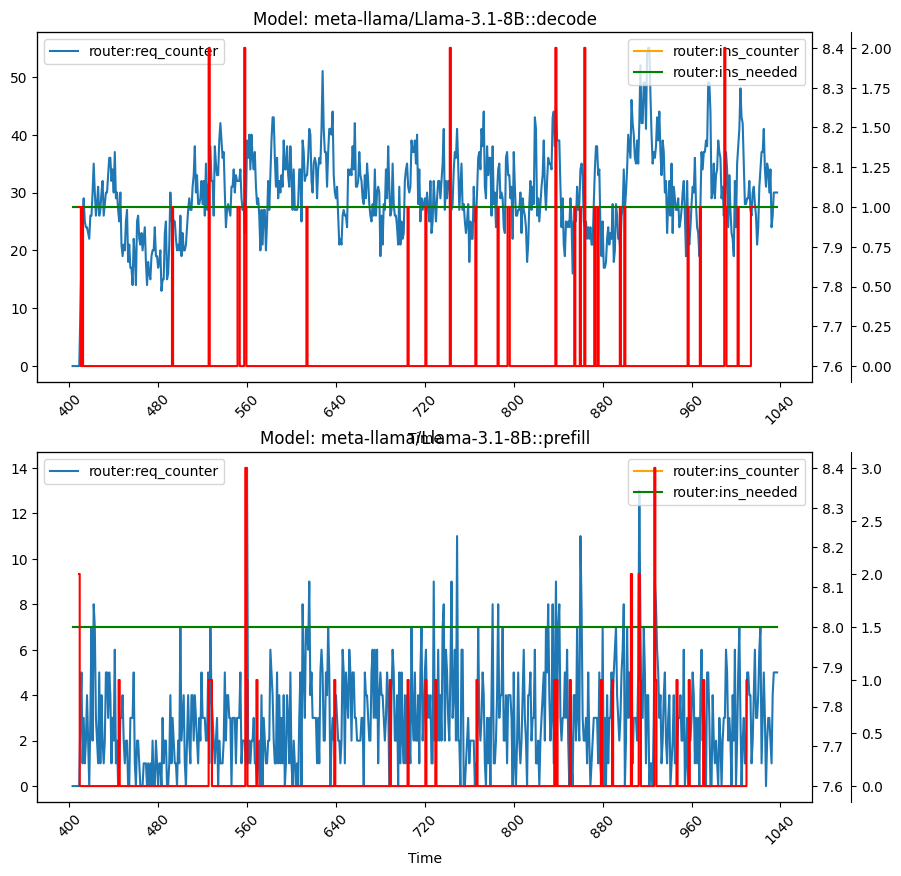

In [8]:
import numpy as np
req_counter = report['prom_data']
prefill_model_name = "meta-llama/Llama-3.1-8B::prefill"
decode_model_name = "meta-llama/Llama-3.1-8B::decode"

router_metrics = req_counter.get("router", {})
num_models = len(router_metrics)
fig, axes = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))
ttft_violate_timestamps = []
tpot_violate_timestamps = []
for request in requests:
    ttft_attain, tbt_attain = request.satisfy_SLO()
    if not ttft_attain:
        ttft_violate_timestamps.append(request.arrival_time - router_start_time)
    if not tbt_attain:
        tpot_violate_timestamps.append(request.arrival_time - router_start_time)

    
for i, (model_name, metrics) in enumerate(router_metrics.items()):
    ax = axes[i] if num_models > 1 else axes
    req_counter_values = metrics.get(req_counter_metric, [])
    req_counter_values = [
        t for t in req_counter_values 
        if float(t[0]) <= router_end_time
    ]
    timestamps = [float(t[0]) for t in req_counter_values]
    timestamp_offsets = [t - router_start_time for t in timestamps]
    ax.plot(
        timestamp_offsets,
        [float(t[1]) for t in req_counter_values],
        label=req_counter_metric
    )
    ax2 = ax.twinx()
    ins_counter_values = metrics.get(ins_counter_metric, [])
    ins_counter_values = [
        t for t in ins_counter_values 
        if float(t[0]) <= router_end_time
    ]
    timestamps = [float(t[0]) for t in ins_counter_values]
    timestamp_offsets = [t - router_start_time for t in timestamps]
    ax2.plot(
        timestamp_offsets,
        [float(t[1]) for t in ins_counter_values],
        label=ins_counter_metric,
        color='orange'
    )
    ins_needed_values = metrics.get(ins_needed_metric, [])
    ins_needed_values = [
        t for t in ins_needed_values 
        if float(t[0]) <= router_end_time
    ]
    timestamps = [float(t[0]) for t in ins_needed_values]
    base_timestamp = min(timestamps)
    timestamp_offsets = [t - router_start_time for t in timestamps]
    ax2.plot(
        timestamp_offsets,
        [float(t[1]) for t in ins_needed_values],
        label=ins_needed_metric,
        color='green'
    )
    if model_name.endswith("::prefill"):
        if ttft_violate_timestamps == []:
            continue
        if hasattr(ttft_violate_timestamps[0], "timestamp"):
            times_values = [t.timestamp() for t in ttft_violate_timestamps]
        else:
            times_values = ttft_violate_timestamps
        router_err_file = f"{run_log_dir}/router.err"
        timeout_offsets = extract_timeout_offsets(router_err_file, router_start_time)
        print(f"Model {model_name} has {len(timeout_offsets)} timeout errors.")
        times_values += timeout_offsets
        times = np.array(times_values)
    elif model_name.endswith("::decode"):
        if tpot_violate_timestamps == []:
            continue
        if hasattr(tpot_violate_timestamps[0], "timestamp"):
            times = np.array([t.timestamp() for t in tpot_violate_timestamps])
        else:
            times = np.array(tpot_violate_timestamps)

    # Window size (in seconds)
    window_size = 1.0  

    # Create bins
    t_min, t_max = times.min(), times.max()
    bins = np.arange(t_min, t_max + window_size, window_size)

    # Count violations in each window
    counts, bin_edges = np.histogram(times, bins=bins)

    # Plot counts vs time
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax3 = ax.twinx()
    ax3.plot(bin_centers, counts, drawstyle="steps-mid", color="r", label="violations per window")
    
    ax3.spines["right"].set_position(("axes", 1.05))  # 15% to the right of ax1
    
    ax.set_title(f"Model: {model_name}")
    ax.set_xlabel("Time")
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # ax2.set_xlim([158, 166])
    ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # ax2.set_ylim([0.9,2.1])
    # ax2.set_xlim(496, 504)
    # ax2.set_xlim(500, 560)

In [9]:
import re
import glob
import pandas as pd
from datetime import datetime
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import os
from datetime import datetime, timezone, timedelta

# Regex patterns
alloc_sent_pattern = re.compile(
    r"\[(.*?)\] LMCache INFO:.*alloc sent NOW req=(\S+)"
)
alloc_reply_pattern = re.compile(
    r"\[(.*?)\] LMCache INFO:.*alloc got-reply req_id=(\S+)"
)
transfer_done_pattern = re.compile(
    r"\[(.*?)\] LMCache INFO:.*transfer DONE for req_id=(\S+), duration: ([\d\.]+) ms"
)

# Regex for stripping ANSI color codes
ansi_escape = re.compile(r"\x1B\[[0-9;]*[mK]")

records = {}

def parse_timestamp(ts_str):
    # Example: "2025-09-02 22:48:40,649"
    ts = datetime.strptime(ts_str, "%Y-%m-%d %H:%M:%S,%f")
    # Convert to Singapore timezone
    ts = ts.replace(tzinfo=timezone.utc) - timedelta(hours=8)
    # Convert to float seconds offset
    return ts.timestamp() - router_start_time

# Iterate over all worker error logs
for fname in glob.glob(os.path.join(run_log_dir, "worker_*.err")):
    with open(fname, "r") as f:
        for line in f:
            line = ansi_escape.sub("", line)  # remove ANSI escapes

            m1 = alloc_sent_pattern.search(line)
            if m1:
                ts_str, req_id = m1.groups()
                ts = parse_timestamp(ts_str)
                records.setdefault(req_id, {})["alloc_start"] = ts
                continue

            m2 = alloc_reply_pattern.search(line)
            if m2:
                ts_str, req_id = m2.groups()
                ts = parse_timestamp(ts_str)
                records.setdefault(req_id, {})["alloc_reply"] = ts
                continue

            m3 = transfer_done_pattern.search(line)
            if m3:
                ts_str, req_id, duration = m3.groups()
                ts = parse_timestamp(ts_str)
                records.setdefault(req_id, {})["transfer_done"] = ts
                records[req_id]["transfer_latency"] = float(duration) / 1000.0  # ms -> s
                continue

# Convert to DataFrame
rows = []
for req_id, v in records.items():
    if "alloc_start" in v and "alloc_reply" in v:
        alloc_latency = v["alloc_reply"] - v["alloc_start"]
        if alloc_latency >= 1:
            print(f"Request {req_id} has high alloc latency: {alloc_latency:.3f}s")
    else:
        alloc_latency = None
    rows.append({
        "req_id": req_id,
        "alloc_start": v.get("alloc_start"),
        "alloc_latency": alloc_latency,
        "transfer_done": v.get("transfer_done"),
        "transfer_latency": v.get("transfer_latency"),
    })

df = pd.DataFrame(rows).sort_values("alloc_start")

# Plot

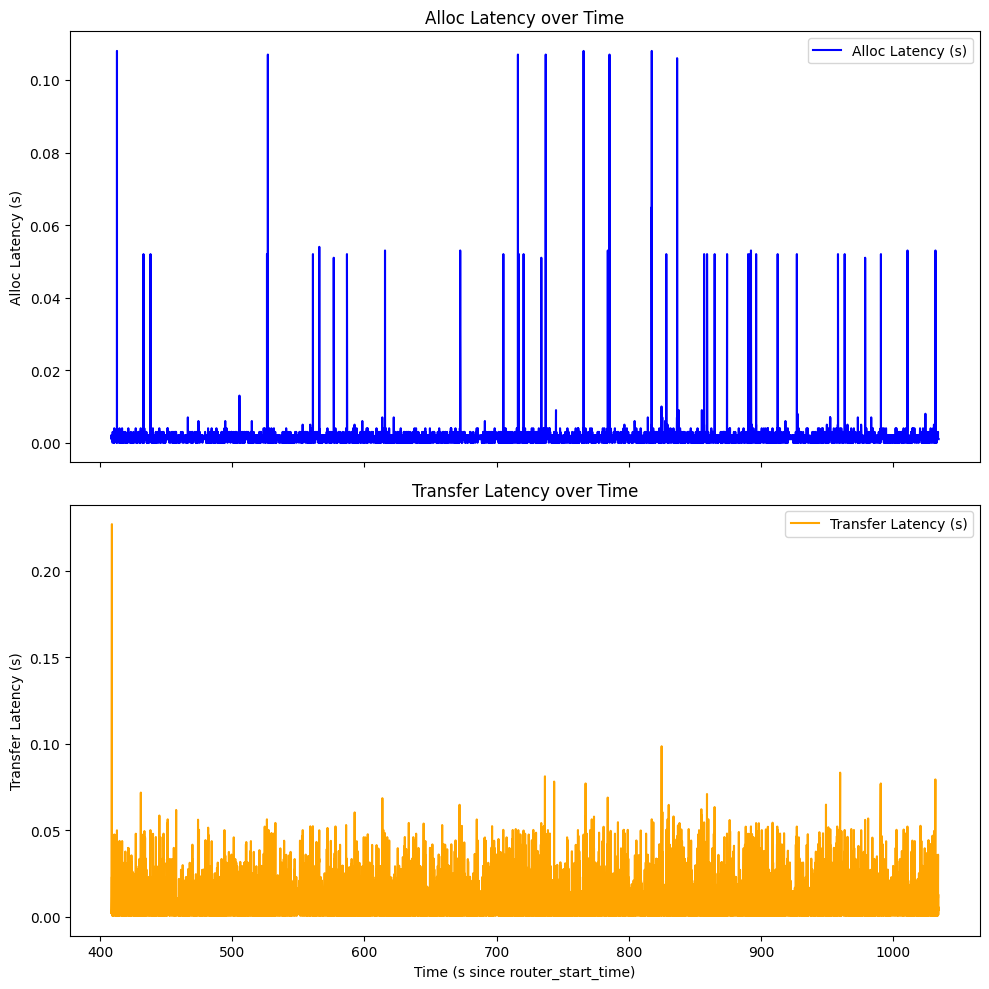

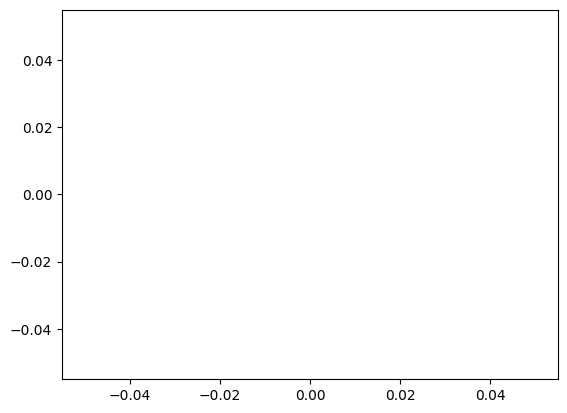

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# First subplot: Alloc latency
axes[0].plot(df["alloc_start"], df["alloc_latency"], label="Alloc Latency (s)", color="blue")
axes[0].set_ylabel("Alloc Latency (s)")
axes[0].set_title("Alloc Latency over Time")
axes[0].legend()

# Second subplot: Transfer latency
axes[1].plot(df["transfer_done"], df["transfer_latency"], label="Transfer Latency (s)", color="orange")
axes[1].set_xlabel("Time (s since router_start_time)")
axes[1].set_ylabel("Transfer Latency (s)")
axes[1].set_title("Transfer Latency over Time")
axes[1].legend()

plt.tight_layout()
plt.show()
arrivals = []
ttfts = []
for request in requests:
    if request.waiting_latency == 0:
        arrival = request.arrival_time - router_start_time
        ttft = request.ttft
        arrivals.append(arrival)
        ttfts.append(ttft)

plt.plot(arrivals, ttfts)

In [11]:
violated_reqs = []
pd_same_node_count = 0
for request in requests:
    if request.arrival_time - router_start_time >= 500 and request.arrival_time - router_start_time <= 525:
        ttft_attain, tbt_attain = request.satisfy_SLO()
        if not ttft_attain:
            violated_reqs.append(request)
            ts = request.arrival_time - router_start_time
            print(f"{ts}, {request.id}: length: {request.prompt_tokens}, {request.ttft}, locality: {request.pd_same_node}")
            if request.pd_same_node:
                pd_same_node_count += 1

print(f"Total violated requests: {len(violated_reqs)}, pd_same_node: {pd_same_node_count}")

Total violated requests: 0, pd_same_node: 0


# Coldstart Values

In [12]:

router_data = report['prom_data']['router']
for model_name in router_data.keys():
    coldstart_metrics = router_data[model_name][coldstart_metric]
    coldstart_values = [t[1] for t in coldstart_metrics]
    coldstart_set = set(coldstart_values)
    print(f"Model: {model_name}, coldstart values: {coldstart_set}")

Model: meta-llama/Llama-3.1-8B::decode, coldstart values: {'NaN', '9.033799516', '11.064336805'}
Model: meta-llama/Llama-3.1-8B::prefill, coldstart values: {'11.034384449', 'NaN', '8.05667432'}


# Router Counters

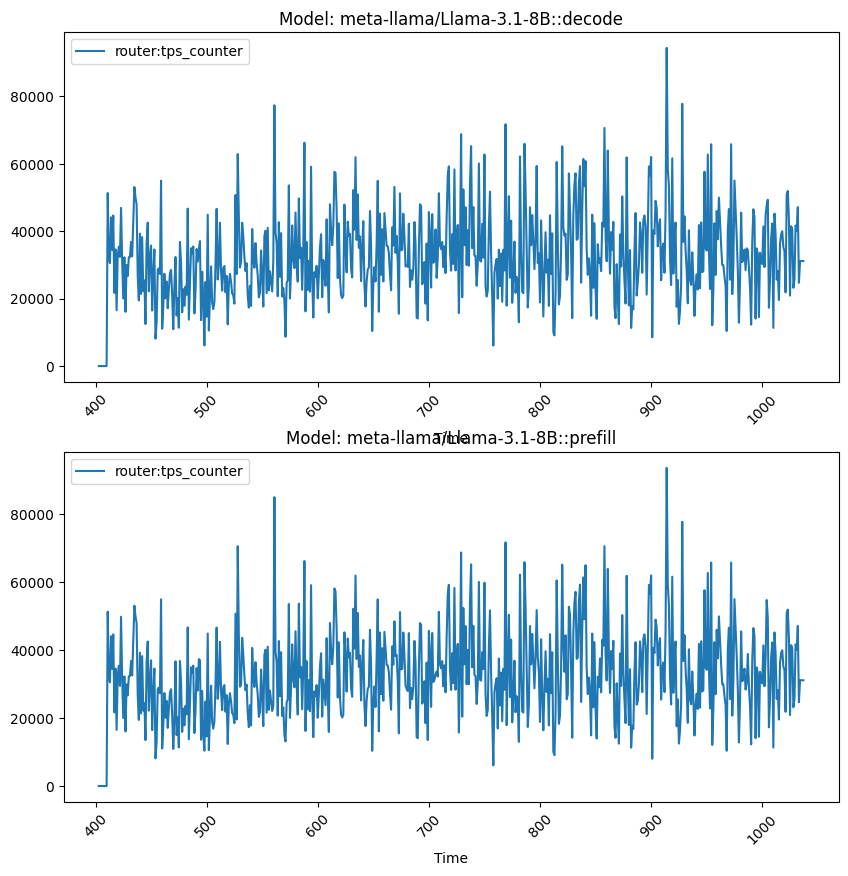

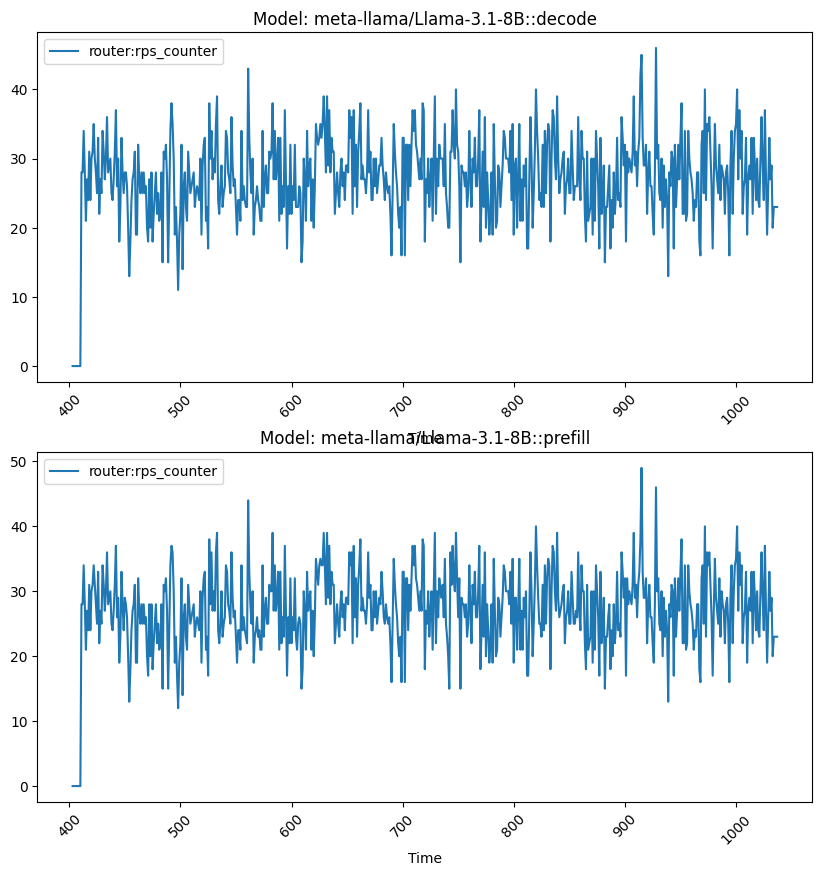

In [13]:

router_metrics = req_counter.get("router", {})
num_models = len(router_metrics)
fig, axes = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))
metric_name = tps_counter_metric
for i, (model_name, metrics) in enumerate(router_metrics.items()):
    ax = axes[i] if num_models > 1 else axes
    tok_counter_values = metrics.get(metric_name, [])
    tok_counter_values = [
        t for t in tok_counter_values 
        if float(t[0]) <= router_end_time
    ]
    timestamps = [float(t[0]) for t in tok_counter_values]
    timestamp_offsets = [t - router_start_time for t in timestamps]
    ax.plot(
        timestamp_offsets,
        [float(t[1]) for t in tok_counter_values],
        label=metric_name
    )
    ax.set_title(f"Model: {model_name}")
    ax.set_xlabel("Time")
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left')

fig, axes = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))
metric_name = rps_counter_metric
for i, (model_name, metrics) in enumerate(router_metrics.items()):
    ax = axes[i] if num_models > 1 else axes
    tok_counter_values = metrics.get(metric_name, [])
    tok_counter_values = [
        t for t in tok_counter_values 
        if float(t[0]) <= router_end_time
    ]
    timestamps = [float(t[0]) for t in tok_counter_values]
    timestamp_offsets = [t - router_start_time for t in timestamps]
    ax.plot(
        timestamp_offsets,
        [float(t[1]) for t in tok_counter_values],
        label=metric_name
    )
    ax.set_title(f"Model: {model_name}")
    ax.set_xlabel("Time")
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left')


Text(0, 0.5, 'Prompt tokens')

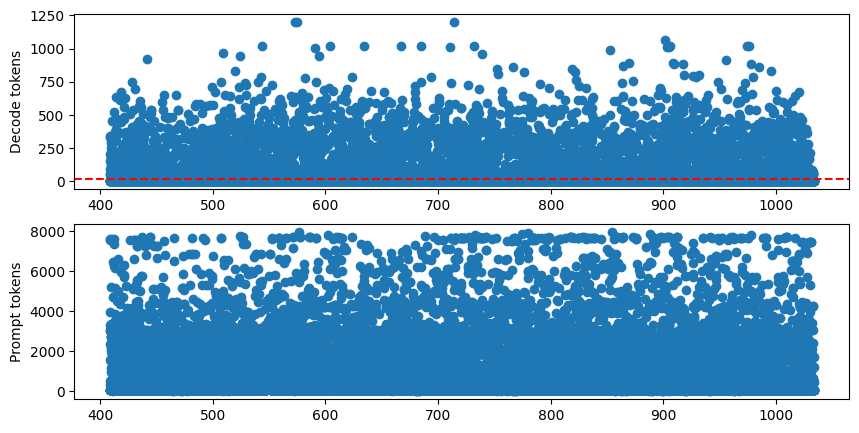

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Convert arrival times to seconds (assuming arrival_time is in seconds already)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
arrival_times = np.array([req.arrival_time - router_start_time for req in requests])
input_tokens = np.array([req.prompt_tokens for req in requests])
output_tokens = np.array([req.decode_tokens for req in requests])
axes[0].plot(arrival_times, output_tokens, 'o')
# axes[0].set_xlim(519, 524)
# axes[0].set_ylim(0, 100)
axes[0].axhline(y=16, color='r', linestyle='--')
axes[0].set_ylabel("Decode tokens")
axes[1].plot(arrival_times, input_tokens, 'o')
# axes[1].set_xlim(519, 524)
axes[1].set_ylabel("Prompt tokens")


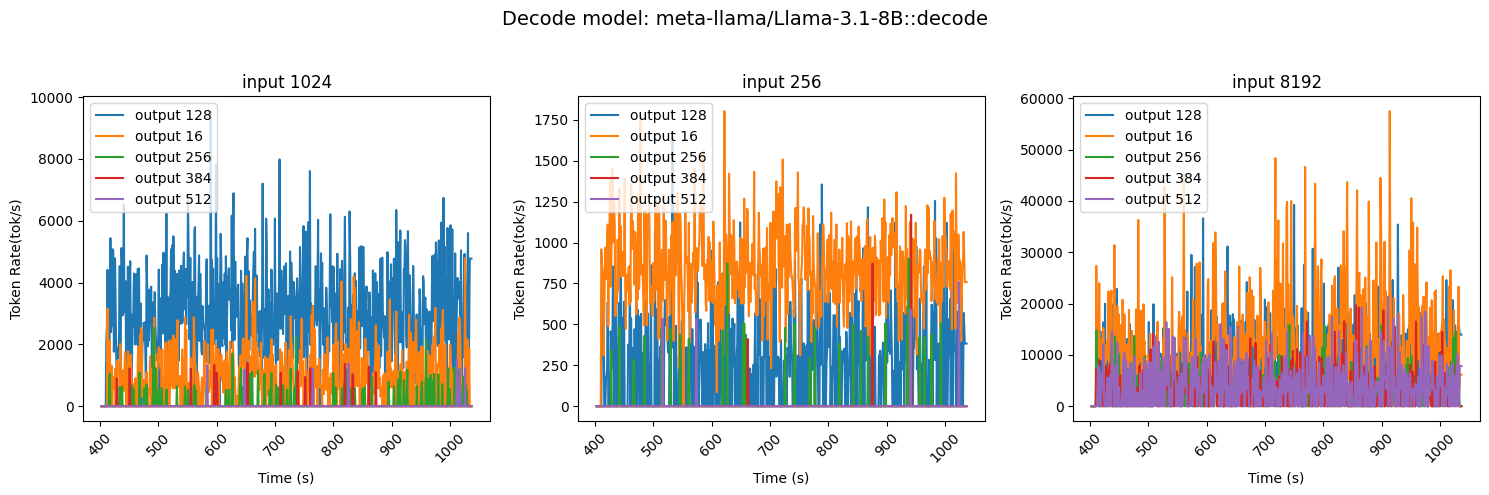

In [15]:
router_metrics = req_counter.get("router", {})
num_models = len(router_metrics)
import matplotlib.pyplot as plt
from collections import defaultdict

metric_name = tps_counter_map_metric

for model_name, metrics in router_metrics.items():
    if not model_name.endswith("::decode"):
        continue

    tok_counter_values = metrics.get(metric_name, {})
    if not tok_counter_values:
        continue

    # Group request_types by input length
    grouped = defaultdict(dict)
    for request_type, values in tok_counter_values.items():
        # request_type looks like "input1024_output128"
        parts = request_type.split("_")
        input_len = parts[0].replace("input", "")
        output_len = parts[1].replace("output", "")
        grouped[input_len][output_len] = values

    num_inputs = len(grouped)
    fig, axes = plt.subplots(1, num_inputs, figsize=(5*num_inputs, 5), sharex=True)
    if num_inputs == 1:
        axes = [axes]

    for ax, (input_len, outputs) in zip(axes, grouped.items()):
        for output_len, values in outputs.items():
            # Filter values within time range
            filtered = [t for t in values if float(t[0]) <= router_end_time]
            timestamps = [float(t[0]) for t in filtered]
            timestamp_offsets = [t - router_start_time for t in timestamps]

            ax.plot(
                timestamp_offsets,
                [float(t[1]) for t in filtered],
                label=f"output {output_len}"
            )

        ax.set_title(f"input {input_len}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Token Rate(tok/s)")
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left')

    fig.suptitle(f"Decode model: {model_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

# SLO Attainment Rate

In [16]:
from datetime import datetime, timedelta
import pytz
import re

def count_requests_within_one_minute(run_log_dir):
    router_file_path = f"{run_log_dir}/router.err"
    first_request_arrival_time = None
    sg_tz = pytz.timezone("Asia/Singapore")
    
    # Regex to extract timestamp
    timestamp_pattern = re.compile(r"(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}\.\d+).*arrived!")
    
    with open(router_file_path, "r") as f:
        lines = f.readlines()
    
    # Find first arrival
    for line in lines:
        match = timestamp_pattern.search(line)
        if match:
            first_request_arrival_time = datetime.strptime(match.group(1), "%Y/%m/%d %H:%M:%S.%f")
            first_request_arrival_time = sg_tz.localize(first_request_arrival_time)
            break
    
    if first_request_arrival_time is None:
        return 0, None  # no matching lines found
    
    # Calculate cutoff time (+1 minute)
    cutoff_time = first_request_arrival_time + timedelta(minutes=1)
    
    # Count lines within the 1-minute window
    count = 0
    for line in lines:
        match = timestamp_pattern.search(line)
        if match:
            line_time = datetime.strptime(match.group(1), "%Y/%m/%d %H:%M:%S.%f")
            line_time = sg_tz.localize(line_time)
            if first_request_arrival_time <= line_time < cutoff_time:
                count += 1
    
    # Convert cutoff timestamp to float (seconds since epoch)
    cutoff_timestamp_float = cutoff_time.timestamp()
    
    return count, cutoff_timestamp_float

In [17]:
filtered_out_count, cutoff_time = count_requests_within_one_minute(run_log_dir)
print(f"Within the first minute, {filtered_out_count} requests arrived.")

ttft_attain_count = 0
tbt_attain_count = 0
total_attain_count = 0
valid_requests = [req for req in requests if req.arrival_time >= cutoff_time]
valid_total_request_count = total_request_count - filtered_out_count
print(f"After discarding requests in the first minute, {valid_total_request_count} requests remain.")

tpot_violate_reqs = []
for request in valid_requests:
    ttft_attain, tbt_attain = request.satisfy_SLO()
    if ttft_attain:
        ttft_attain_count += 1
    
    if tbt_attain:
        tbt_attain_count += 1
    else:
        tpot_violate_reqs.append(request)
    
    if ttft_attain and tbt_attain:
        total_attain_count += 1

ttft_attain_rate = ttft_attain_count / valid_total_request_count if valid_total_request_count > 0 else 0
tbt_attain_rate = tbt_attain_count / valid_total_request_count if valid_total_request_count > 0 else 0
total_attain_rate = total_attain_count / valid_total_request_count if valid_total_request_count > 0 else 0

print(f"Among {valid_total_request_count} requests (after discarding first minute), "
      f"{ttft_attain_count} attain TTFT, {tbt_attain_count} attain TBT, {total_attain_count} attain total")
print(f"total attain rate: {total_attain_rate*100:.1f}%, "
      f"TTFT attain rate: {ttft_attain_rate*100:.1f}%, "
      f"TBT attain rate: {tbt_attain_rate*100:.1f}%")


Within the first minute, 1620 requests arrived.
After discarding requests in the first minute, 15540 requests remain.
Among 15540 requests (after discarding first minute), 15508 attain TTFT, 15504 attain TBT, 15472 attain total
total attain rate: 99.6%, TTFT attain rate: 99.8%, TBT attain rate: 99.8%


Total TBT violated requests: 36
Among TBT violated requests, 0 have zero waiting latency


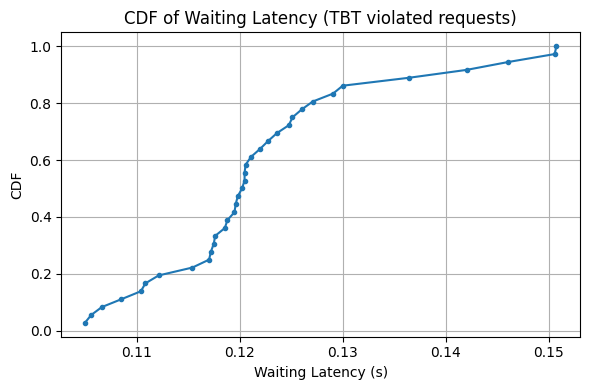

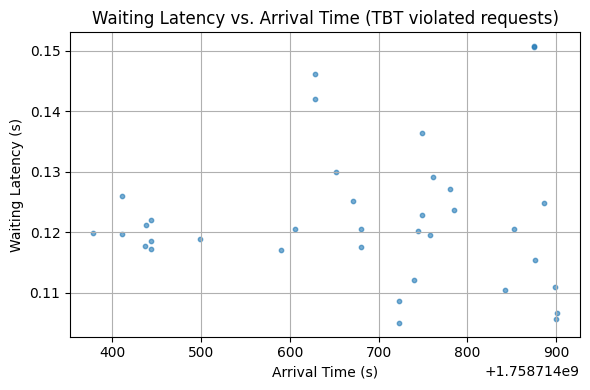

In [18]:
print(f"Total TBT violated requests: {len(tpot_violate_reqs)}")
waiting_latencys = [req.waiting_latency for req in tpot_violate_reqs]
import matplotlib.pyplot as plt
import numpy as np

# Extract
arrival_times = [req.arrival_time for req in tpot_violate_reqs]
waiting_latencys = [req.waiting_latency for req in tpot_violate_reqs]
zero_waiting_count = sum(1 for lat in waiting_latencys if lat == 0)
print(f"Among TBT violated requests, {zero_waiting_count} have zero waiting latency")

# 1. CDF of waiting latency
sorted_lat = np.sort(waiting_latencys)
cdf = np.arange(1, len(sorted_lat)+1) / len(sorted_lat)

plt.figure(figsize=(6, 4))
plt.plot(sorted_lat, cdf, marker='.', linestyle='-')
plt.xlabel("Waiting Latency (s)")
plt.ylabel("CDF")
plt.title("CDF of Waiting Latency (TBT violated requests)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Waiting latency vs arrival time
plt.figure(figsize=(6, 4))
plt.scatter(arrival_times, waiting_latencys, alpha=0.6, s=10)
plt.xlabel("Arrival Time (s)")
plt.ylabel("Waiting Latency (s)")
plt.title("Waiting Latency vs. Arrival Time (TBT violated requests)")
plt.grid(True)
plt.tight_layout()
plt.show()



# CDFs

In [19]:
import numpy as np
import matplotlib.pyplot as plt
def plot_cdf(data, ax=None, label=None, **kwargs):
    """
    Plot the CDF of a 1D array on the given matplotlib Axes.

    Parameters:
    - data: array-like, the input values.
    - ax: matplotlib.axes.Axes, optional. If None, a new figure and axes will be created.
    - label: str, optional label for the CDF curve.
    - **kwargs: other keyword arguments passed to ax.plot()

    Returns:
    - ax: The matplotlib Axes object with the plot.
    """
    data = np.asarray(data)
    data_sorted = np.sort(data)
    cdf = np.linspace(0, 1, len(data_sorted), endpoint=False)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(data_sorted, cdf, label=label, **kwargs)
    ax.set_ylabel("CDF")
    ax.set_xlabel("Value")
    if label:
        ax.legend()

    return ax

## E2E Latency

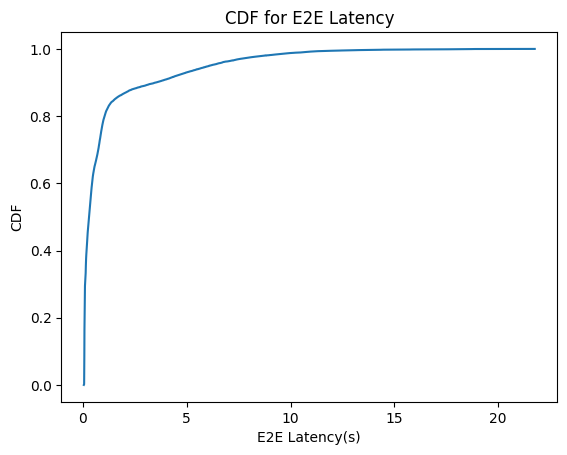

max e2e latency: 21.8s


In [20]:
e2e_latencys = []
ttfts = []
tpots = []
waiting_latencys = []
for request in requests:
    e2e = request.ttft + request.waiting_latency + request.decode_latency
    ttft = request.ttft
    tpot = request.decode_latency / request.decode_tokens
    waiting_latency = request.waiting_latency
    e2e_latencys.append(e2e) 
    ttfts.append(ttft)
    tpots.append(tpot)
    waiting_latencys.append(waiting_latency)

fig, ax = plt.subplots()
ax = plot_cdf(e2e_latencys, ax)
ax.set_xlabel("E2E Latency(s)")
ax.set_title(f"CDF for E2E Latency")
plt.show()
print(f"max e2e latency: {max(e2e_latencys):.1f}s")



## TTFT Latency

Mean ttft for same node: 0.0963476170954162, 6436 requests
Mean ttft for cross node: 0.10242515755695712, 10724 requests


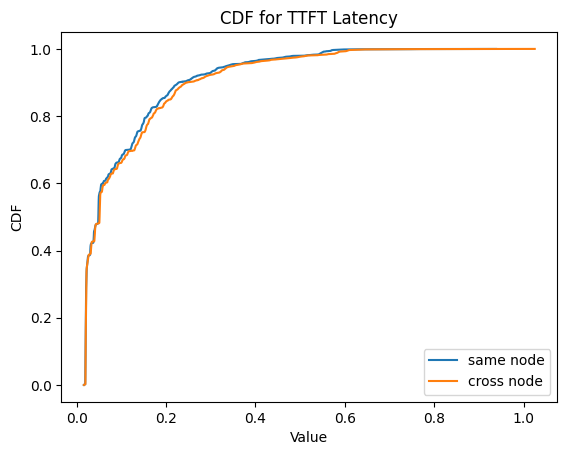

In [21]:
ttft_same_node = []
ttft_cross_node = []
for request in requests:
    if request.pd_same_node == 0:
        ttft_cross_node.append(request.ttft)
    else:
        ttft_same_node.append(request.ttft)
print(f"Mean ttft for same node: {np.mean(ttft_same_node)}, {len(ttft_same_node)} requests")
print(f"Mean ttft for cross node: {np.mean(ttft_cross_node)}, {len(ttft_cross_node)} requests")
fig, ax = plt.subplots()
ax = plot_cdf(ttft_same_node, ax, label=f"same node")
ax = plot_cdf(ttft_cross_node, ax ,label=f"cross node")
ax.legend()
ax.set_title(f"CDF for TTFT Latency")
plt.show()

In [22]:

queueing_disagg = []
queueing_agg = []
for request in requests:
    if request.waiting_latency == 0:
        queueing_agg.append(request.queueing_latency)
    else:
        queueing_disagg.append(request.queueing_latency)
print(f"Mean queueing latency for disagg: {np.mean(queueing_disagg)}")
print(f"Mean queueing latency for agg: {np.mean(queueing_agg)}")

Mean queueing latency for disagg: 0.003890636042281464
Mean queueing latency for agg: nan


/home/lrq619/anaconda3/envs/py/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lrq619/anaconda3/envs/py/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Transimission Latency

Across node: 66.8ms
On same node: 117.0ms
Across node: 125.4ms
Across node: 165.6ms
Across node: 139.1ms
Across node: 109.2ms
On same node: 281.6ms
On same node: 19.3ms
Across node: 133.2ms
Across node: 21.3ms
Across node: 49.2ms
On same node: 21.3ms
On same node: 20.8ms
Across node: 154.3ms
Across node: 21.0ms
On same node: 40.8ms
Across node: 174.4ms
Across node: 159.3ms
On same node: 46.7ms
On same node: 59.9ms
On same node: 21.1ms
On same node: 16.6ms
On same node: 17.3ms
On same node: 22.8ms
Across node: 100.2ms
Across node: 80.9ms
Across node: 49.4ms
On same node: 18.9ms
Across node: 24.4ms
On same node: 18.6ms
Across node: 21.3ms
Across node: 20.7ms
On same node: 17.4ms
Across node: 22.1ms
Across node: 20.5ms
Across node: 19.7ms
Across node: 19.6ms
On same node: 22.2ms
On same node: 19.0ms
Across node: 18.6ms
Across node: 36.1ms
Across node: 64.1ms
Across node: 116.8ms
Across node: 50.4ms
Across node: 29.9ms
On same node: 18.6ms
Across node: 24.5ms
Across node: 29.5ms
On same no

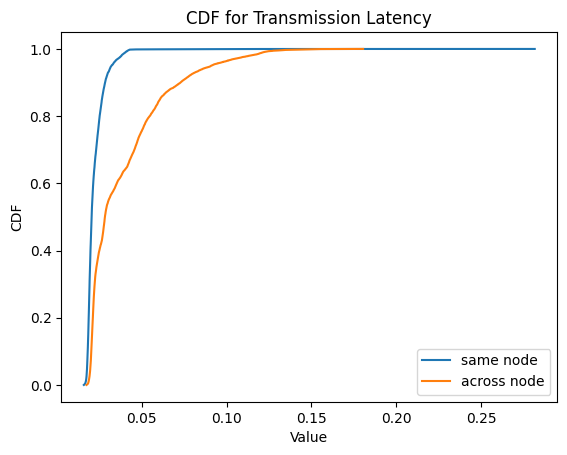

In [23]:
transmission_same_node = []
transmission_across_node = []
for request in requests:
    if request.pd_same_node == 1:
        print(f"On same node: {request.waiting_latency*1000:.1f}ms")
        transmission_same_node.append(request.waiting_latency)
    else:
        print(f"Across node: {request.waiting_latency*1000:.1f}ms")
        transmission_across_node.append(request.waiting_latency)
print(f"Mean transmission for disagg: {np.mean(transmission_same_node)}")
fig, ax = plt.subplots()
ax = plot_cdf(transmission_same_node, ax, label=f"same node")
ax = plot_cdf(transmission_across_node, ax ,label=f"across node")
ax.legend()
ax.set_title(f"CDF for Transmission Latency")
plt.show()

## Decode TTFT

Mean ttft for disagg: 0.02497078112233213, number of requests: 17160
Mean ttft for agg: nan, number of requests: 0


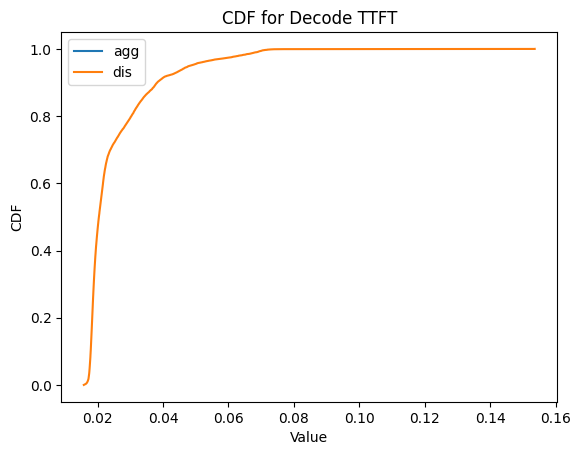

In [24]:

decode_ttft_disagg = []
decode_ttft_agg = []
for request in requests:
    if request.waiting_latency == 0:
        decode_ttft_agg.append(request.ttft)
        if request.ttft > 2.5:
            print(f"Large ttft: {request.ttft}, request prompt length: {request.prompt_tokens}, decode length: {request.decode_tokens}")
    else:
        decode_ttft_disagg.append(request.decode_ttft)
print(f"Mean ttft for disagg: {np.mean(decode_ttft_disagg)}, number of requests: {len(decode_ttft_disagg)}")
print(f"Mean ttft for agg: {np.mean(decode_ttft_agg)}, number of requests: {len(decode_ttft_agg)}")
fig, ax = plt.subplots()
ax = plot_cdf(decode_ttft_agg, ax, label=f"agg")
ax = plot_cdf(decode_ttft_disagg, ax ,label=f"dis")
ax.legend()
ax.set_title(f"CDF for Decode TTFT")
plt.show()

Text(0.5, 1.0, 'Decode TTFT vs. Arrival Time (Stable Requests)')

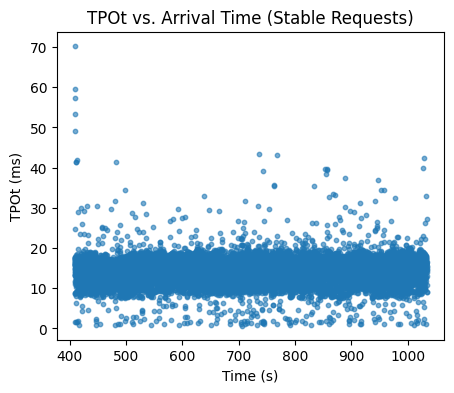

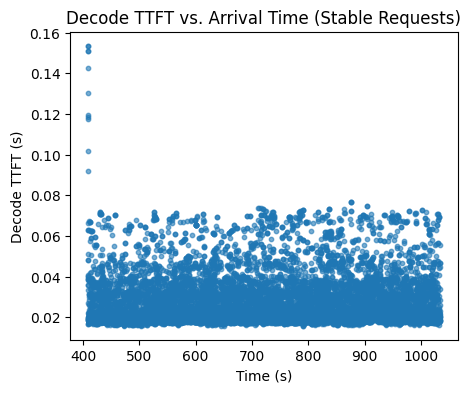

In [25]:
request_timestamps = []
request_tpots = []
request_decode_ttfts = []
for request in requests:
    if request.waiting_latency == 0:
        continue
    tpot = request.decode_latency / request.decode_tokens
    request_tpots.append(tpot*1000)
    request_decode_ttfts.append(request.decode_ttft)
    request_timestamps.append(request.arrival_time - router_start_time)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(request_timestamps, request_tpots, alpha=0.6, s=10)
ax.set_xlabel("Time (s)")
ax.set_ylabel("TPOt (ms)")
ax.set_title("TPOt vs. Arrival Time (Stable Requests)")

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(request_timestamps, request_decode_ttfts, alpha=0.6, s=10)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Decode TTFT (s)")
ax.set_title("Decode TTFT vs. Arrival Time (Stable Requests)")

## LMCache Hit Rate

Total 17193 hit rate records, 0 with hit rate <= 0.1


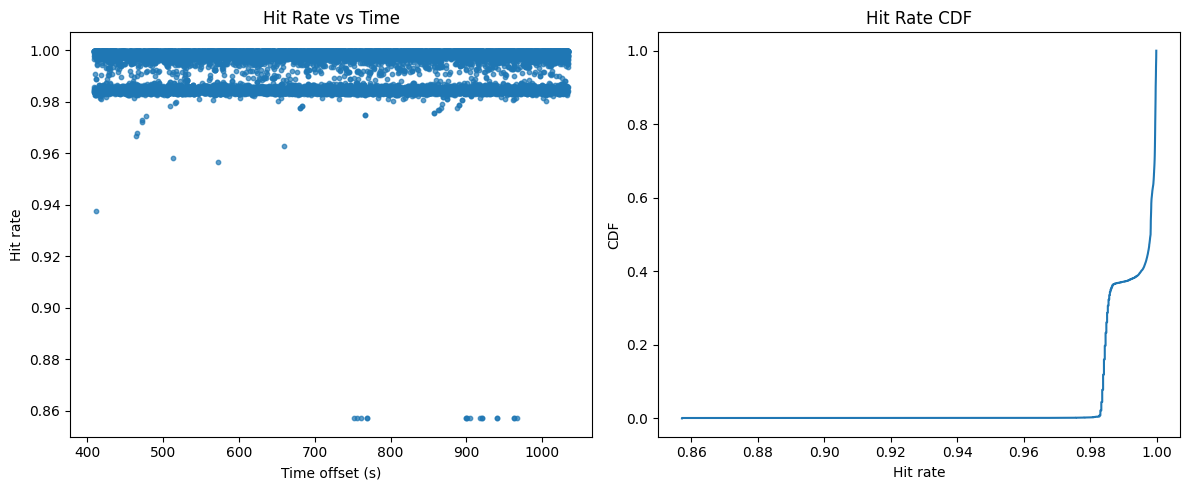

In [26]:
import os
import glob
import re
from datetime import datetime
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import numpy as np

pattern = re.compile(
    r"\[(?P<ts>[\d\-]+\s[\d:,]+)\].*?Total tokens (?P<total>\d+), LMCache hit tokens: (?P<hit>\d+)"
)

timestamps = []
hit_rates = []

for file in glob.glob(os.path.join(run_log_dir, "worker_*.err")):
    with open(file, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = pattern.search(line)
            if not m:
                continue

            ts_str = m.group("ts")
            total_tokens = int(m.group("total"))
            hit_tokens = int(m.group("hit"))

            # convert timestamp to epoch float (Singapore TZ)
            dt = datetime.strptime(ts_str, "%Y-%m-%d %H:%M:%S,%f")
            dt = dt.replace(tzinfo=ZoneInfo("Asia/Singapore"))
            ts_float = dt.timestamp()

            # offset
            offset = ts_float - router_start_time
            hit_rate = hit_tokens / total_tokens if total_tokens > 0 else 0.0

            timestamps.append(offset)
            hit_rates.append(hit_rate)

# Convert to numpy arrays
timestamps = np.array(timestamps)
hit_rates = np.array(hit_rates)
no_hit_count = 0
for rate in hit_rates:
    if rate <= 0.1:
        no_hit_count += 1

print(f"Total {len(hit_rates)} hit rate records, {no_hit_count} with hit rate <= 0.1")

# Sort for CDF
sorted_hits = np.sort(hit_rates)
cdf = np.arange(1, len(sorted_hits) + 1) / len(sorted_hits)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: hit rate vs. time
axes[0].scatter(timestamps, hit_rates, s=10, alpha=0.7)
axes[0].set_title("Hit Rate vs Time")
axes[0].set_xlabel("Time offset (s)")
axes[0].set_ylabel("Hit rate")

# Subplot 2: CDF
axes[1].plot(sorted_hits, cdf)
axes[1].set_title("Hit Rate CDF")
axes[1].set_xlabel("Hit rate")
axes[1].set_ylabel("CDF")

plt.tight_layout()
plt.show()

# LMCache Related Metrics
## LMCache Receiver Put/Get Speed and Buffer Space Occupancy

In [27]:

import re
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from collections import defaultdict

def parse_log_file(log_content):
    """Parse the log file and extract prefill requests"""
    
    # Pattern to match the log lines
    pattern = r'INFO (\d{2}-\d{2} \d{2}:\d{2}:\d{2}) \[logger\.py:\d+\] Received request.*?params: SamplingParams\([^)]*max_tokens=(\d+)[^)]*min_tokens=(\d+)[^)]*\).*?prompt_token_ids: \[([^\]]+)\]'
    
    matches = re.findall(pattern, log_content, re.DOTALL)
    
    prefill_requests = []
    
    for match in matches:
        timestamp_str, max_tokens, min_tokens, token_ids_str = match
        
        # Check if it's a prefill request (max_tokens == min_tokens == 1)
        if max_tokens == '1' and min_tokens == '1':
            # Parse timestamp
            timestamp = datetime.strptime(f"2025-{timestamp_str}", "%Y-%m-%d %H:%M:%S")
            
            # Count tokens in prompt_token_ids
            token_ids = [int(x.strip()) for x in token_ids_str.split(',')]
            context_length = len(token_ids)
            
            prefill_requests.append({
                'timestamp': timestamp,
                'context_length': context_length
            })
    
    return prefill_requests

def calculate_token_rate(requests, window_seconds=5, base_time=None):
    """Calculate token arrival rate averaged over time windows"""
    
    if not requests:
        return [], []
    
    # Sort requests by timestamp
    requests.sort(key=lambda x: x['timestamp'])
    
    # Get the first timestamp as reference
    if base_time is not None:
        start_time = base_time
    else:
        start_time = requests[0]['timestamp']
    
    # Group requests by time windows
    time_windows = defaultdict(int)  # time_offset -> total_tokens
    
    for req in requests:
        time_offset = (req['timestamp'] - start_time).total_seconds()
        window_start = int(time_offset // window_seconds) * window_seconds
        time_windows[window_start] += req['context_length']
    
    # Convert to lists for plotting
    times = sorted(time_windows.keys())
    token_rates = [time_windows[t] / window_seconds for t in times]  # tokens per second
    
    return times, token_rates




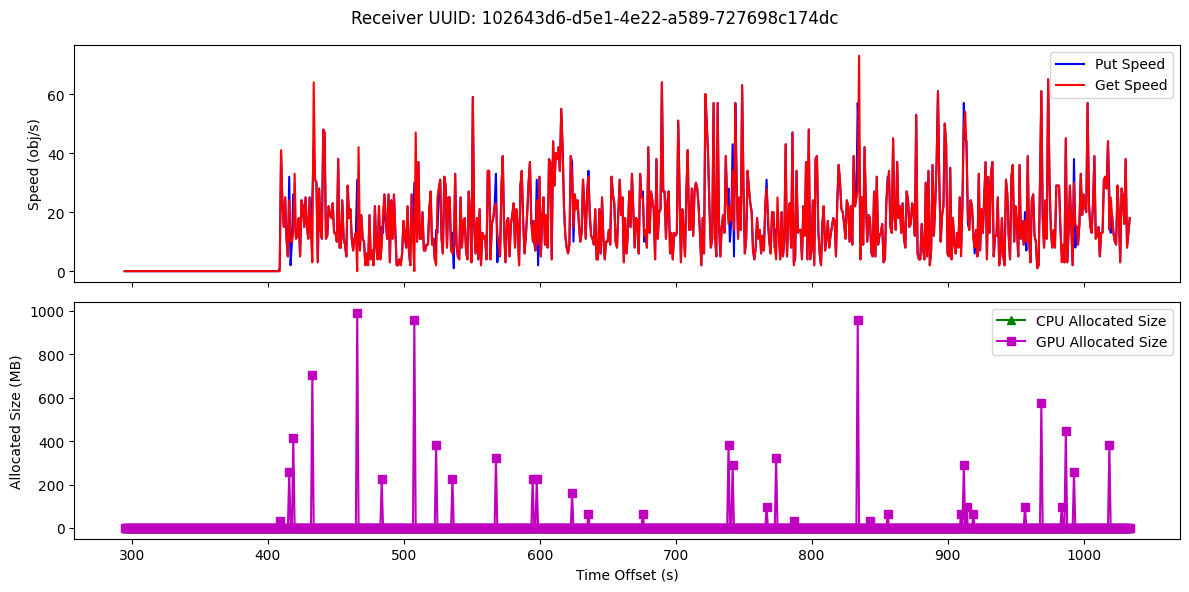

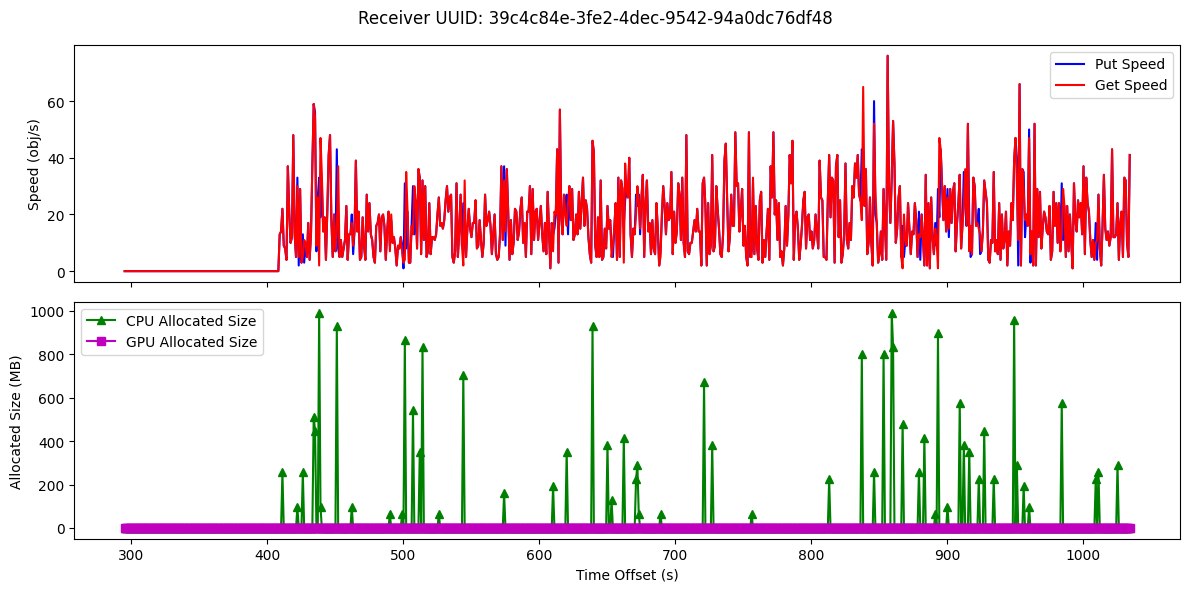

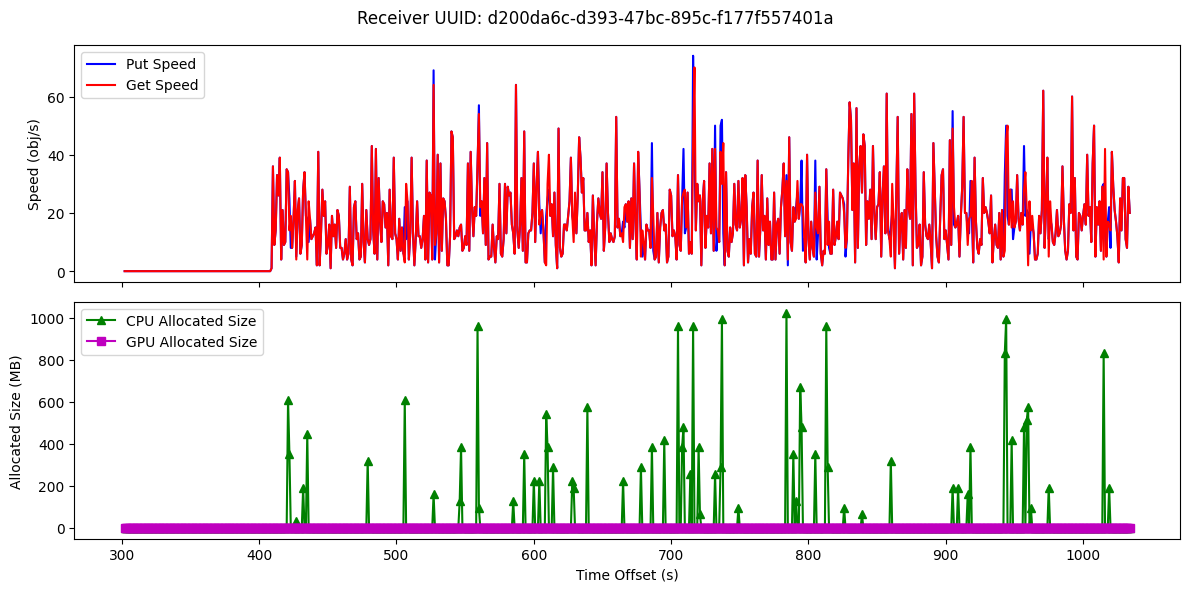

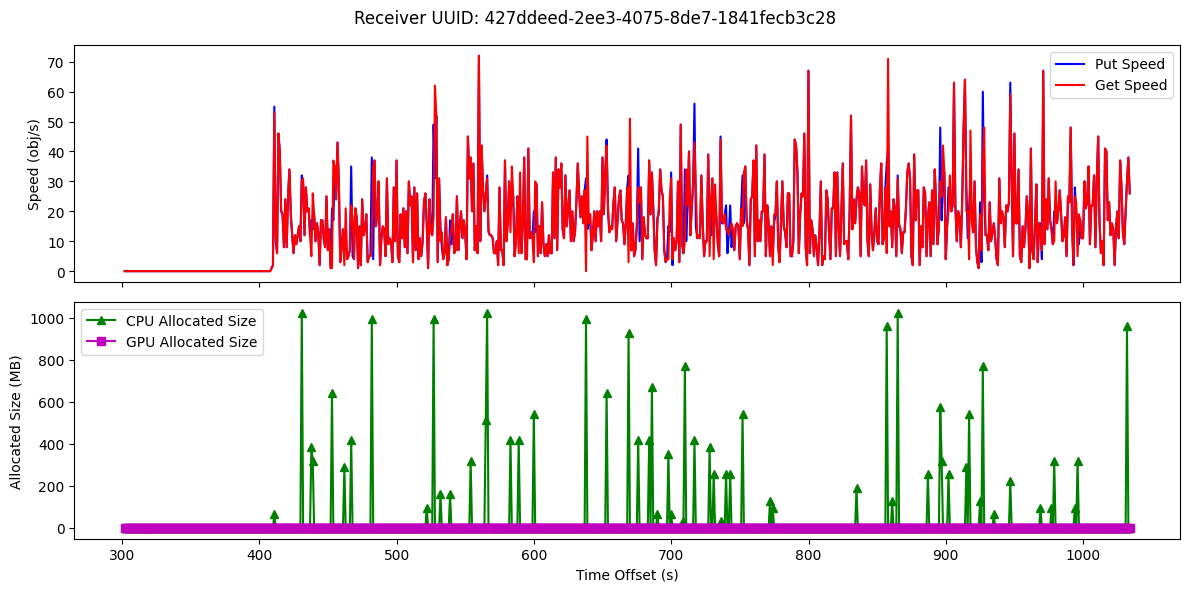

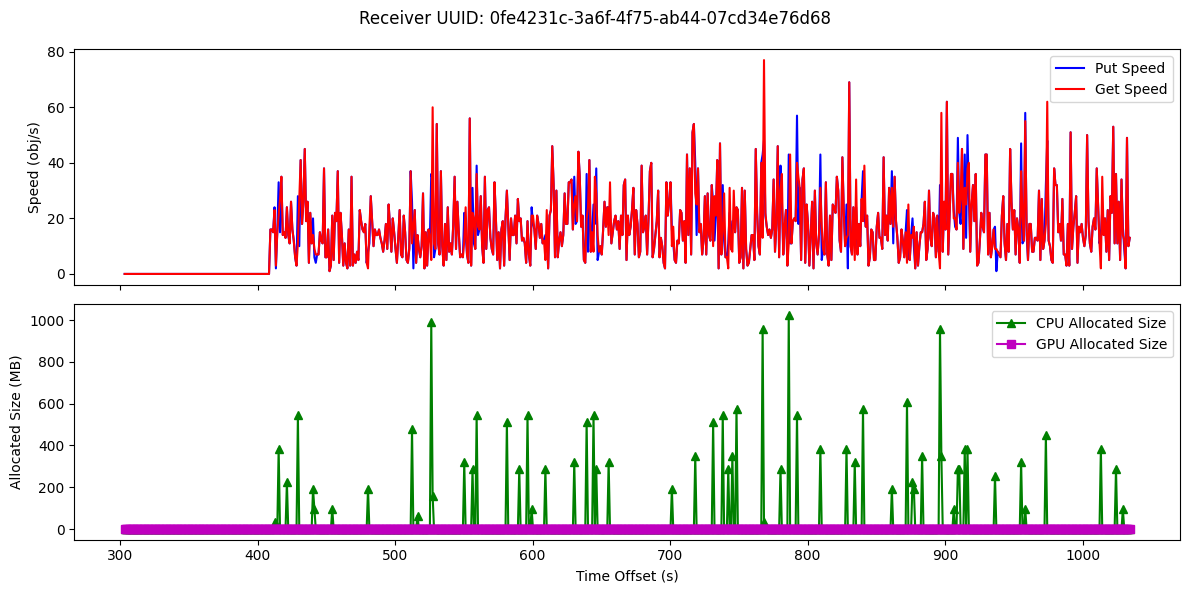

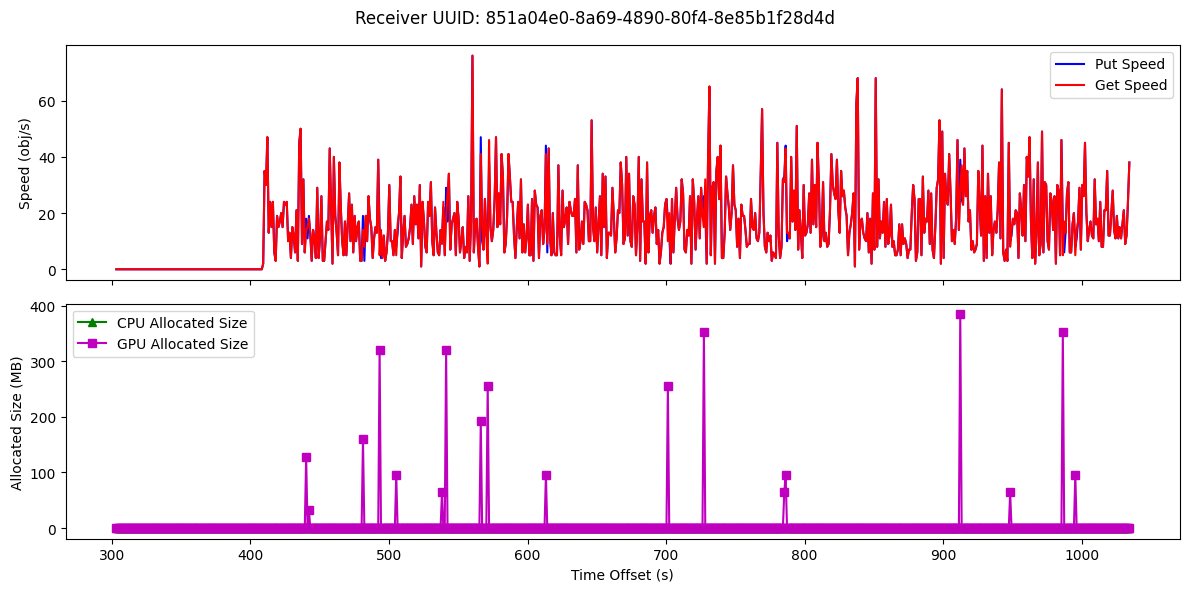

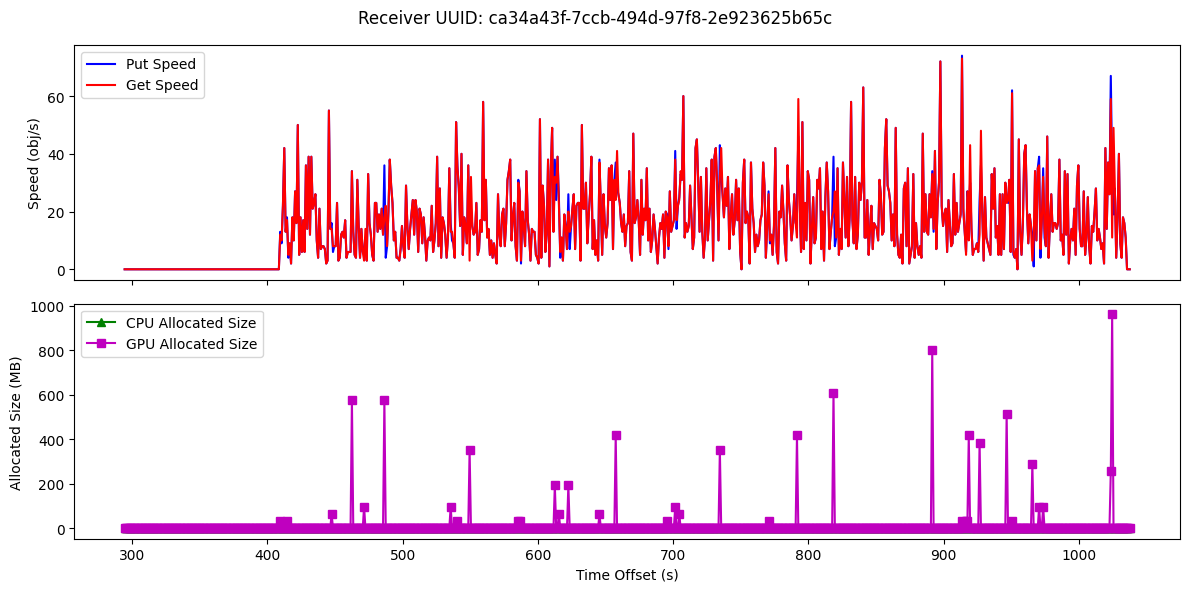

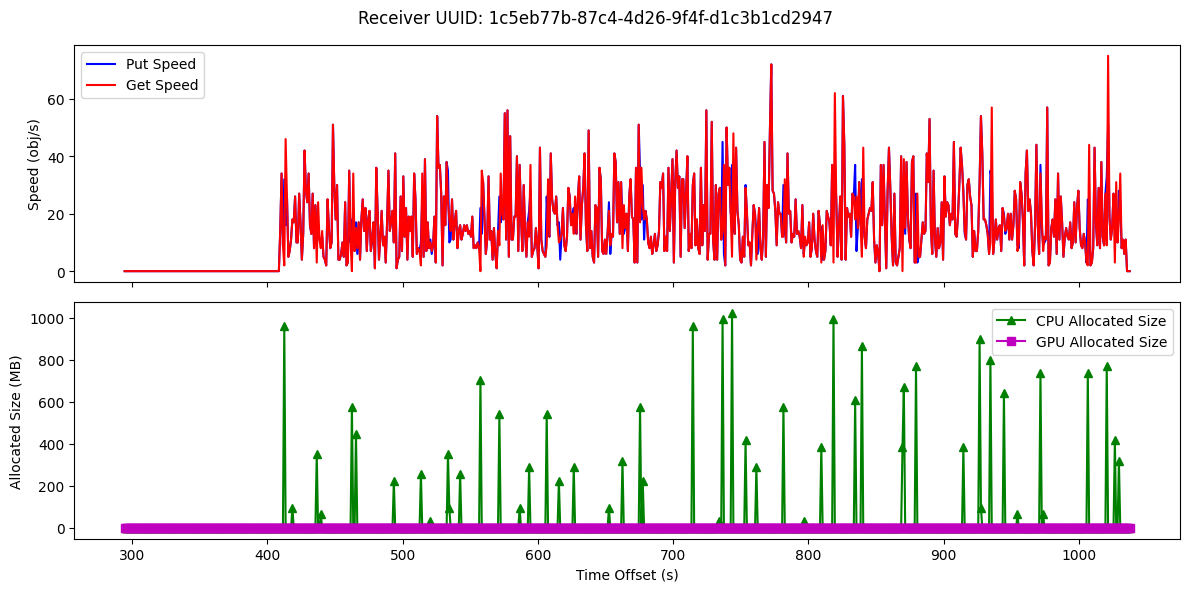

In [28]:
import re
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import os
from collections import defaultdict
import glob

# Adjust regex to capture CPU and GPU allocated sizes
pattern = re.compile(
    r"\[(?P<ts>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})\].*?"
    r"\[ReceiverStat\],.*?"
    r"uuid:(?P<uuid>[a-f0-9\-]+).*?"
    r"total gpu allocated size:\s+(?P<size_gpu>[\d.]+)\s+MB.*?"
    r"total cpu allocated size:\s+(?P<size_cpu>[\d.]+)\s+MB.*?"
    r"put_speed:\s+(?P<put>[\d.]+)\s+obj/s.*?"
    r"get_speed:\s+(?P<get>[\d.]+)\s+obj/s"
)

# Data structure per UUID
data = defaultdict(lambda: {"ts": [], "size_cpu": [], "size_gpu": [], "put": [], "get": []})

# Parse all worker_*.err files
log_files = glob.glob(os.path.join(run_log_dir, "worker_*.err"))

if not log_files:
    print(f"No worker_*.err files found under {run_log_dir}")

for file_path in log_files:
    with open(file_path, "r") as f:
        for line in f:
            m = pattern.search(line)
            if not m:
                continue
            ts = datetime.strptime(m.group("ts"), "%Y-%m-%d %H:%M:%S,%f")
            ts = ts.replace(tzinfo=timezone(timedelta(hours=8)))  # Singapore time
            uuid = m.group("uuid")
            data[uuid]["ts"].append(ts)
            data[uuid]["size_cpu"].append(float(m.group("size_cpu")))
            data[uuid]["size_gpu"].append(float(m.group("size_gpu")))
            data[uuid]["put"].append(float(m.group("put")))
            data[uuid]["get"].append(float(m.group("get")))

if not data:
    print("No matching log lines found in any worker_*.err")

# Plot per-UUID
for uuid, vals in data.items():
    # Sort by timestamp in case logs from multiple files are interleaved
    sorted_entries = sorted(
        zip(vals["ts"], vals["size_cpu"], vals["size_gpu"], vals["put"], vals["get"])
    )
    ts_sorted, size_cpu_sorted, size_gpu_sorted, put_sorted, get_sorted = zip(*sorted_entries)

    time_offsets = [t.timestamp() - router_start_time for t in ts_sorted]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    fig.suptitle(f"Receiver UUID: {uuid}")

    # Put/Get speed
    ax1.plot(time_offsets, put_sorted, 'b-', label="Put Speed")
    ax1.plot(time_offsets, get_sorted, 'r-', label="Get Speed")
    ax1.set_ylabel("Speed (obj/s)")
    ax1.legend()

    # CPU/GPU allocated size
    ax2.plot(time_offsets, size_cpu_sorted, 'g-', marker='^', label="CPU Allocated Size")
    ax2.plot(time_offsets, size_gpu_sorted, 'm-', marker='s', label="GPU Allocated Size")
    ax2.set_xlabel("Time Offset (s)")
    ax2.set_ylabel("Allocated Size (MB)")
    ax2.legend()

    plt.tight_layout()
    plt.show()



## LMCache Sender Buffer Occupancy

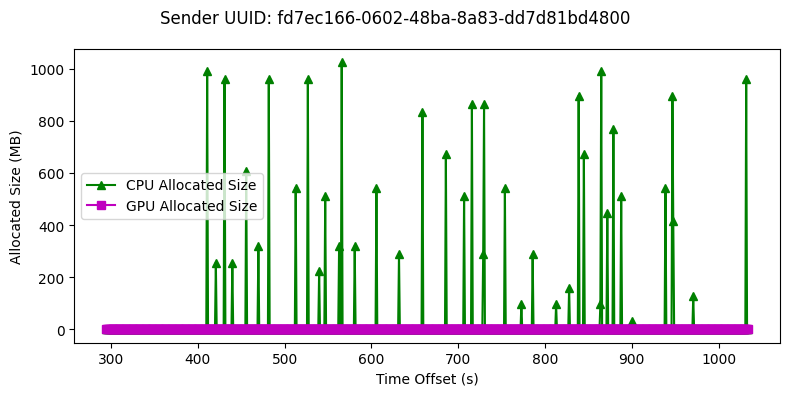

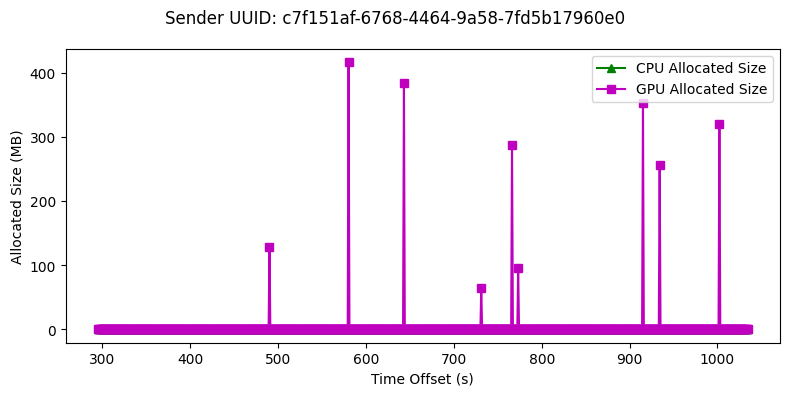

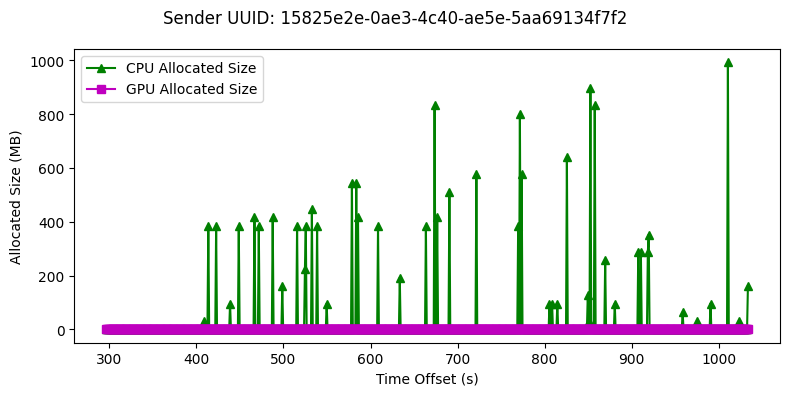

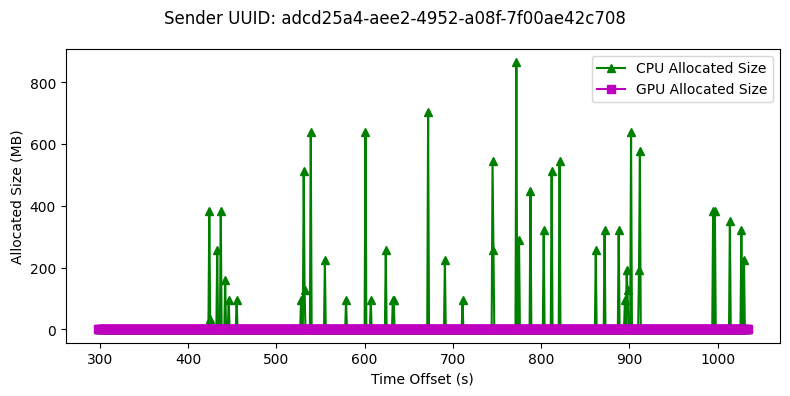

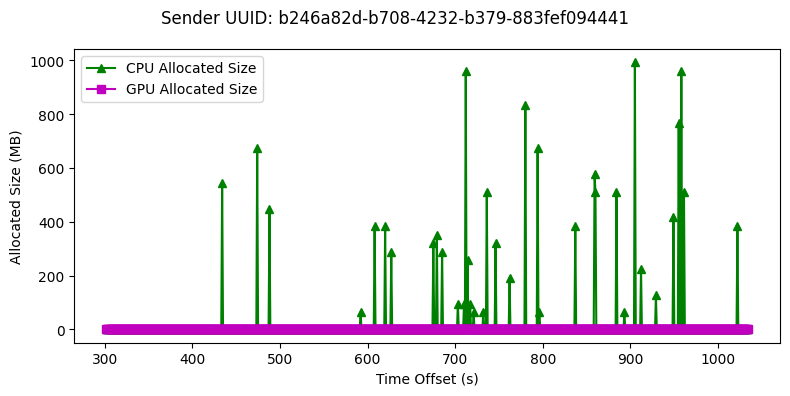

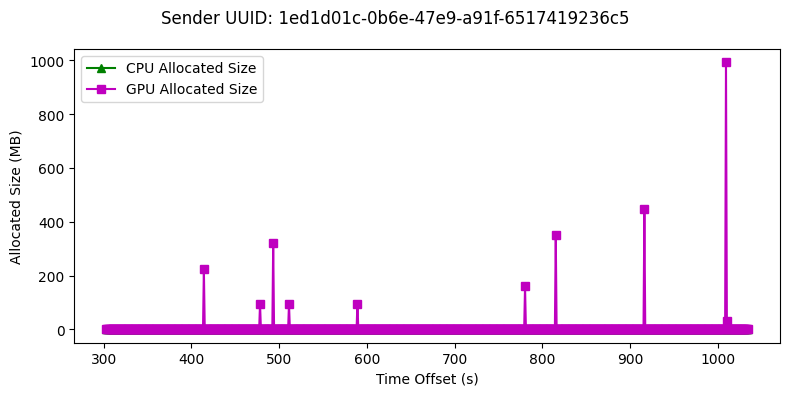

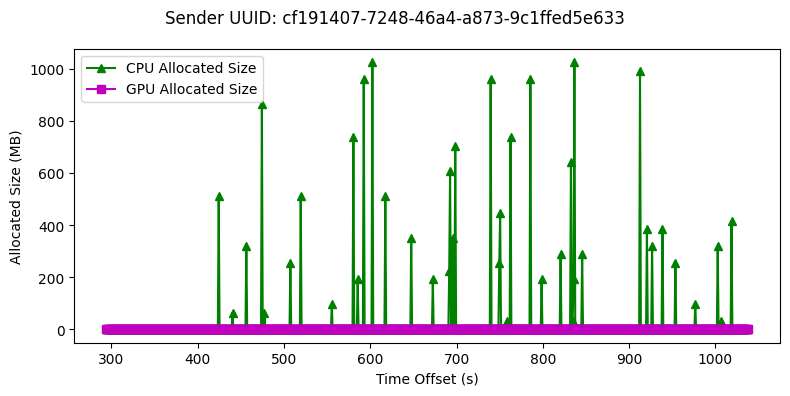

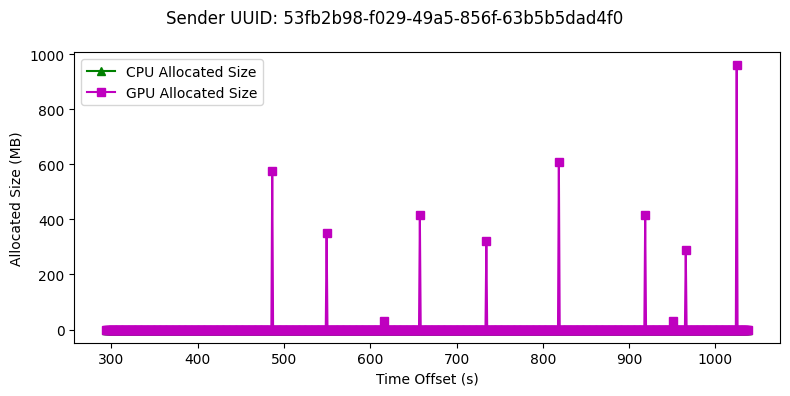

In [29]:

import re
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import os
from collections import defaultdict
import glob

# Adjust regex to capture CPU and GPU allocated sizes
pattern = re.compile(
    r"\[(?P<ts>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})\].*?"
    r"\[SenderStat\],.*?"
    r"uuid:(?P<uuid>[a-f0-9\-]+).*?"
    r"total gpu allocated size:\s+(?P<size_gpu>[\d.]+)\s+MB.*?"
    r"total cpu allocated size:\s+(?P<size_cpu>[\d.]+)\s+MB.*?"
)

# Data structure per UUID
data = defaultdict(lambda: {"ts": [], "size_cpu": [], "size_gpu": [], "put": [], "get": []})

# Parse all worker_*.err files
log_files = glob.glob(os.path.join(run_log_dir, "worker_*.err"))

if not log_files:
    print(f"No worker_*.err files found under {run_log_dir}")

for file_path in log_files:
    with open(file_path, "r") as f:
        for line in f:
            m = pattern.search(line)
            if not m:
                continue
            ts = datetime.strptime(m.group("ts"), "%Y-%m-%d %H:%M:%S,%f")
            ts = ts.replace(tzinfo=timezone(timedelta(hours=8)))  # Singapore time
            uuid = m.group("uuid")
            data[uuid]["ts"].append(ts)
            data[uuid]["size_cpu"].append(float(m.group("size_cpu")))
            data[uuid]["size_gpu"].append(float(m.group("size_gpu")))

if not data:
    print("No matching log lines found in any worker_*.err")

# Plot per-UUID
for uuid, vals in data.items():
    # Sort by timestamp in case logs from multiple files are interleaved
    sorted_entries = sorted(
        zip(vals["ts"], vals["size_cpu"], vals["size_gpu"])
    )
    ts_sorted, size_cpu_sorted, size_gpu_sorted = zip(*sorted_entries)

    time_offsets = [t.timestamp() - router_start_time for t in ts_sorted]

    fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
    fig.suptitle(f"Sender UUID: {uuid}")


    # CPU/GPU allocated size
    ax.plot(time_offsets, size_cpu_sorted, 'g-', marker='^', label="CPU Allocated Size")
    ax.plot(time_offsets, size_gpu_sorted, 'm-', marker='s', label="GPU Allocated Size")
    ax.set_xlabel("Time Offset (s)")
    ax.set_ylabel("Allocated Size (MB)")
    ax.legend()

    plt.tight_layout()
    plt.show()


## LMCache Finished Speed

the first request sent at 407.9667088985443s
the first request finished at 408.66556310653687s
Number of time windows: 126
avg finished speed: 34322.95238095238 tok/s


Text(0.5, 1.0, 'Finished Speed over Time')

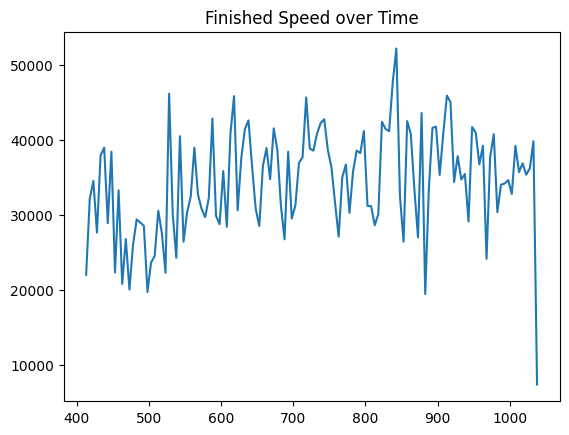

In [30]:

# Lists to store event timestamps when requests are completed
TIME_WINDOW = 5
decode_times = []

# Fill in event lists with only SLO-satisfying requests
finished_tokens = []
prefill_tokens = []
decode_tokens = []
tpots = []
for request_data in loadgen_data:
    if 'error' in request_data:
        continue

    request = RequestData.init_from_dict(request_data)

    arrival_time = request.arrival_time
    decode_finished_time = arrival_time + request.ttft + request.waiting_latency + request.decode_latency


    decode_times.append(decode_finished_time)
    finished_tokens.append(request.decode_tokens+request.prompt_tokens)
    prefill_tokens.append(request.prompt_tokens)
    decode_tokens.append(request.decode_tokens)
    tpot = request.decode_latency / request.decode_tokens if request.decode_tokens > 0 else 0
    tpots.append(tpot)

assert len(decode_times) == len(finished_tokens)

# Step 1: Normalize decode_times to time offsets from base_time
# Assume decode_times[0] is a float Unix timestamp
ts = decode_times[0]

# Define Singapore timezone (UTC+8)
from datetime import datetime, timezone, timedelta
sg_timezone = timezone(timedelta(hours=8))

# Convert to datetime with Singapore timezone
dt_sg = datetime.fromtimestamp(ts, tz=sg_timezone)

# Print it
# base_timestamp = base_time.timestamp()
# time_offsets = [t - base_time.timestamp() for t in decode_times]
time_offsets = [t - router_start_time for t in decode_times]

# Step 2: Bucket the values into fixed-size time windows
max_time = router_end_time - router_start_time
min_time = first_request_sendtime - router_start_time
num_windows = int(np.ceil((max_time - min_time) / TIME_WINDOW))

print(f"the first request sent at {first_request_sendtime - router_start_time}s")
print(f"the first request finished at {min(decode_times) - router_start_time}s")
print(f"Number of time windows: {num_windows}")

window_edges = [i * TIME_WINDOW + min_time for i in range(num_windows + 1)]
window_avgs = []
window_centers = []
r_avgs = []
tpot_avgs = []

for i in range(num_windows):
    start = window_edges[i]
    end = window_edges[i + 1]

    # Gather tokens in this time window
    tokens_in_window = [
        tok  for t, tok in zip(time_offsets, finished_tokens)
        if start <= t < end
    ]
    prefill_toks_in_window = [
        tok  for t, tok in zip(time_offsets, prefill_tokens)
        if start <= t < end
    ]

    decode_toks_in_window = [
        tok  for t, tok in zip(time_offsets, decode_tokens)
        if start <= t < end
    ]

    tpot_in_window = [
        tpot for t, tpot in zip(time_offsets, tpots)
        if start <= t < end
    ]

    if tokens_in_window:
        avg = sum(tokens_in_window) / TIME_WINDOW
        r = np.mean(np.asarray(prefill_toks_in_window) / np.array(decode_toks_in_window))
    else:
        r = 0
        avg = 0

    window_avgs.append(avg)
    r_avgs.append(r)
    tpot_avgs.append(np.mean(tpot_in_window) if tpot_in_window else 0)
    # window_centers.append((start + end) / 2)
    window_centers.append(end)


# Step 3: Plot
plt.figure()
plt.plot(window_centers, window_avgs, label='Finished Speed')
print(f"avg finished speed: {np.mean(window_avgs)} tok/s")
# plt.figure()
plt.title('Finished Speed over Time')
# r_avgs_array = np.array(r_avgs)
# tpot_avgs_array = np.array(tpot_avgs)
# calculated_finished_speed = (r_avgs_array+1) / tpot_avgs_array
# ax1.plot(window_centers, calculated_finished_speed, label='Calculated Finished Speed')

# Memory Leakage Monitor

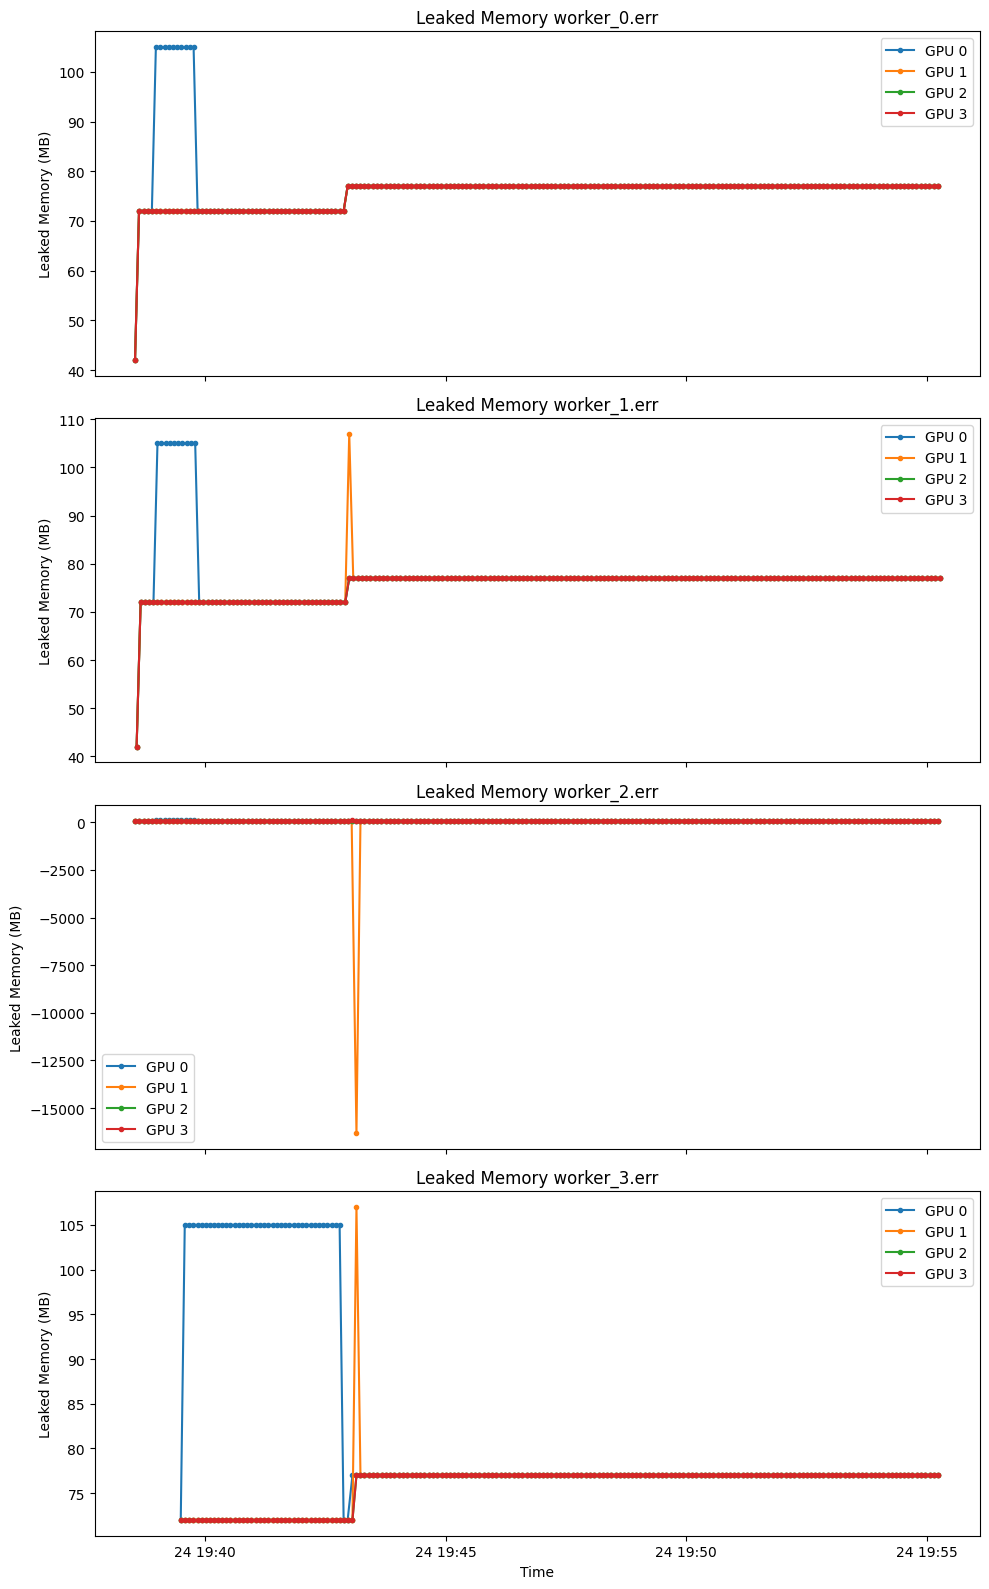

In [31]:

import os
import re
import matplotlib.pyplot as plt
from datetime import datetime
# Regex to capture timestamp and GPU leak list
line_pattern = re.compile(
    r"\[(?P<ts>[\d\-]+\s[\d:]+)\]\s+\[Leaked Memory\]\s+(?P<gpus>\[.*\])"
)

def parse_worker_log(filepath):
    """Parse a worker_x.err file, return timestamps and gpu_leaks dict."""
    timestamps = []
    gpu_leaks = {}  # {gpu_id: [values]}
    
    with open(filepath, "r") as f:
        for line in f:
            m = line_pattern.search(line)
            if not m:
                continue
            
            # Parse timestamp
            ts = datetime.strptime(m.group("ts"), "%Y-%m-%d %H:%M:%S")
            timestamps.append(ts)
            
            # Parse GPU leaks list safely with eval
            gpus = eval(m.group("gpus"))  # e.g. ['GPU 0: 105 MB', ...]
            for gpu_entry in gpus:
                gpu_id, mem_str = gpu_entry.split(":")
                gpu_id = gpu_id.strip()  # "GPU 0"
                mem = int(mem_str.strip().replace("MB", ""))
                
                if gpu_id not in gpu_leaks:
                    gpu_leaks[gpu_id] = []
                gpu_leaks[gpu_id].append(mem)
    
    return timestamps, gpu_leaks


def plot_all_workers(run_log_dir):
    worker_files = sorted(
        [f for f in os.listdir(run_log_dir) if f.startswith("worker_") and f.endswith(".err")]
    )
    
    num_workers = len(worker_files)
    fig, axes = plt.subplots(num_workers, 1, figsize=(10, 4 * num_workers), sharex=True)
    
    if num_workers == 1:
        axes = [axes]  # Ensure iterable
    
    for ax, worker_file in zip(axes, worker_files):
        filepath = os.path.join(run_log_dir, worker_file)
        timestamps, gpu_leaks = parse_worker_log(filepath)
        
        for gpu_id, mem_values in gpu_leaks.items():
            ax.plot(timestamps, mem_values, label=gpu_id, marker="o", markersize=3)
        
        ax.set_title(f"Leaked Memory {worker_file}")
        ax.set_ylabel("Leaked Memory (MB)")
        ax.legend()
    
    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()


plot_all_workers(run_log_dir)

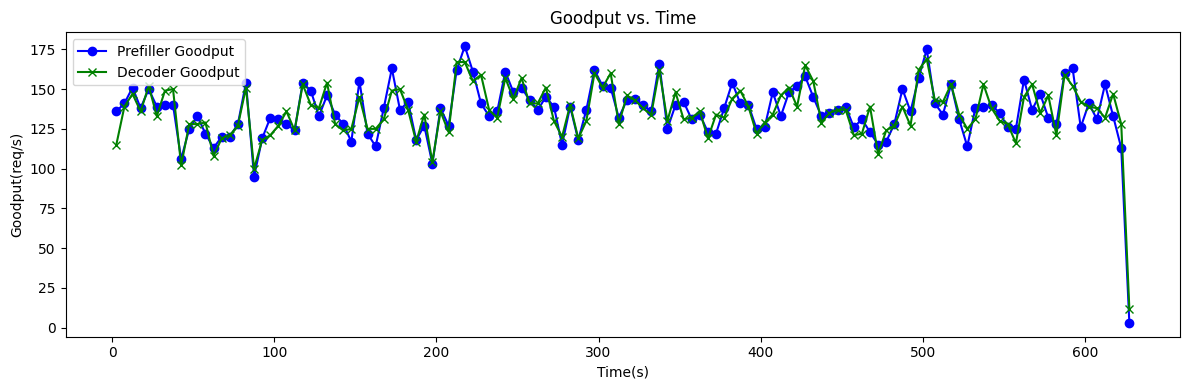

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define a fixed time window for goodput calculation (in seconds)
TIME_WINDOW = 5.0

# Lists to store event timestamps when requests are completed
prefill_times = []
decode_times = []

# Fill in event lists with only SLO-satisfying requests
for request_data in loadgen_data:
    if 'error' in request_data:
        continue

    request = RequestData.init_from_dict(request_data)
    # if not request.satisfy_SLO():
    #     continue

    arrival_time = request.arrival_time
    prefill_finished_time = arrival_time + request.ttft
    decode_finished_time = arrival_time + request.ttft + request.waiting_latency + request.decode_latency

    if request.satisfy_prefill_SLO():
        prefill_times.append(prefill_finished_time)

    if request.satisfy_decode_SLO():
        decode_times.append(decode_finished_time)
    # prefill_times.append(prefill_finished_time)
    # decode_times.append(decode_finished_time)

# Convert to numpy arrays
prefill_times = np.array(prefill_times)
decode_times = np.array(decode_times)

# Normalize all times relative to the first request
start_time = min(prefill_times.min(), decode_times.min())
prefill_times -= start_time
decode_times -= start_time

# Compute time bins
end_time = max(prefill_times.max(), decode_times.max())
bins = np.arange(0, end_time + TIME_WINDOW, TIME_WINDOW)

# Histogram = number of completed requests in each time bin
prefill_goodput, _ = np.histogram(prefill_times, bins)
decode_goodput, _ = np.histogram(decode_times, bins)

# Midpoints for plotting
bin_midpoints = bins[:-1] + TIME_WINDOW / 2

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(bin_midpoints, prefill_goodput, label='Prefiller Goodput', color='blue', marker='o')
plt.plot(bin_midpoints, decode_goodput, label='Decoder Goodput', color='green', marker='x')
plt.xlabel('Time(s)')
plt.ylabel(f'Goodput(req/s)')
plt.title('Goodput vs. Time')
plt.legend()
plt.tight_layout()
plt.show()

# Drift Monitor

We count 17160 requests with drift info, max drift: 6ms


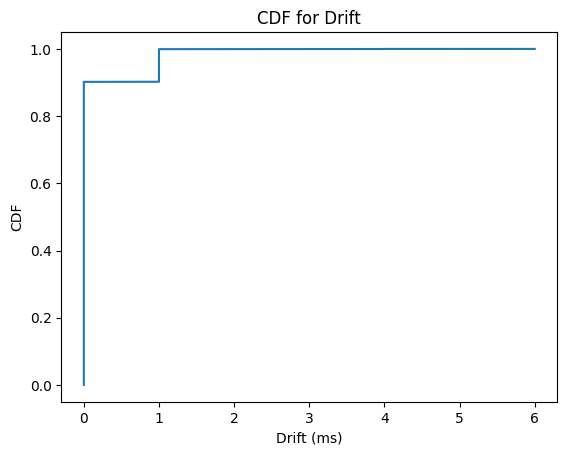

In [33]:
import json
request_datas = []
with open(f"{run_log_dir}/loadgen_result.json", "r") as f:
    for line in f.readlines():
        request_data = json.loads(line)
        request_datas.append(request_data)

drifts = []
for request in request_datas:
    drifts.append(request['response']['drift'])

print(f"We count {len(drifts)} requests with drift info, max drift: {max(drifts)}ms")
fig, ax = plt.subplots()
ax = plot_cdf(drifts, ax)
ax.set_xlabel("Drift (ms)")
ax.set_title(f"CDF for Drift")
plt.show()